# Import the necessary libraries

In [1]:
import import_ipynb
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import plotly.express as px
from sklearn.feature_selection import f_regression, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from workalendar.europe import Romania
from sklearn import preprocessing

# Connect to the database

In [2]:
conn = sqlite3.connect('clean_database.db')
cursor = conn.cursor()

# Check all the tables available within the database

In [3]:
cursor.execute("SELECT name FROM sqlite_master WHERE type ='table';")
print(cursor.fetchall())

[('Meteostat_Data',), ('Entsoe_Data',), ('Entsoe_Meteostat_Data',), ('Entsoe_real_data',), ('Entsoe_real_values_and_Meteostat_data',), ('Entsoe_forecasted_data',), ('Entsoe_forecasted_data_and_Meteostat_data',), ('Feature_selected_real_data',), ('Feature_selected_forecasted_data',)]


# Feature Selection

In [4]:
entsoe_meteostat_forecast = pd.read_sql("SELECT * FROM Entsoe_forecasted_data_and_Meteostat_data;", conn)
entsoe_meteostat_forecast

timestamp  en_gen_forecasted  forecasted_load  \
0      2017-10-02 01:00:00             5185.0           5300.0   
1      2017-10-02 02:00:00             5238.0           5220.0   
2      2017-10-02 03:00:00             5294.0           5200.0   
3      2017-10-02 04:00:00             5352.0           5280.0   
4      2017-10-02 05:00:00             5396.0           5540.0   
...                    ...                ...              ...   
37238  2021-12-31 19:00:00             6848.5           7802.5   
37239  2021-12-31 20:00:00             6657.0           7512.5   
37240  2021-12-31 21:00:00             6540.0           7180.0   
37241  2021-12-31 22:00:00             6425.0           6840.0   
37242  2021-12-31 23:00:00             6117.0           6480.0   

       forecast_exchange_BG_RO  forecast_exchange_HU_RO  \
0                        300.0                    700.0   
1                        300.0                    700.0   
2                        300.0                    700.0   
3                        300.0                    700.0   
4                        300.0                    700.0   
...                        ...                      ...   
37238                   1200.0                    900.0   
37239                   1200.0                    900.0   
37240                   1200.0                    900.0   
37241                   1200.0                    900.0   
37242                   1200.0                    900.0   

       forecast_exchange_RS_RO  forecast_exchange_UA_RO  \
0                        700.0                    100.0   
1                        700.0                    100.0   
2                        700.0                    100.0   
3                        700.0                    100.0   
4                        700.0                    100.0   
...                        ...                      ...   
37238                    500.0                    300.0   
37239                    500.0                    300.0   
37240                    500.0                    300.0   
37241                    500.0                    300.0   
37242                    500.0                    300.0   

       forecast_exchange_RO_BG  forecast_exchange_RO_HU  \
0                        250.0                    450.0   
1                        250.0                    450.0   
2                        250.0                    450.0   
3                        250.0                    450.0   
4                        250.0                    450.0   
...                        ...                      ...   
37238                   1236.0                    800.0   
37239                   1236.0                    800.0   
37240                   1236.0                    800.0   
37241                   1236.0                    800.0   
37242                   1236.0                    800.0   

       forecast_exchange_RO_RS  ...  avg_wind_speed_AB (km/h)  \
0                        500.0  ...                       3.6   
1                        500.0  ...                       3.6   
2                        500.0  ...                       3.6   
3                        500.0  ...                       3.6   
4                        500.0  ...                       3.6   
...                        ...  ...                       ...   
37238                    500.0  ...                      12.6   
37239                    500.0  ...                      12.6   
37240                    500.0  ...                      12.6   
37241                    500.0  ...                      12.6   
37242                    500.0  ...                      12.6   

       avg_wind_speed_B (km/h)  avg_sea-lvl_air_pres_NT (hPa)  \
0                          3.6                         1030.1   
1                          3.6                         1030.1   
2                          3.6                         1030.0   
3                          3.6                         1

> First, I will try to restrict the number of features (for example the sum between all the energy produced by the power plants at a certain period of time result in the total energy produced in that interval) in then look if there is any correlation between the remaining features

### Reducing the number of features (where that is possible)

In [5]:
entsoe_meteostat_forecast_1 = entsoe_meteostat_forecast.copy()
entsoe_meteostat_forecast_1

timestamp  en_gen_forecasted  forecasted_load  \
0      2017-10-02 01:00:00             5185.0           5300.0   
1      2017-10-02 02:00:00             5238.0           5220.0   
2      2017-10-02 03:00:00             5294.0           5200.0   
3      2017-10-02 04:00:00             5352.0           5280.0   
4      2017-10-02 05:00:00             5396.0           5540.0   
...                    ...                ...              ...   
37238  2021-12-31 19:00:00             6848.5           7802.5   
37239  2021-12-31 20:00:00             6657.0           7512.5   
37240  2021-12-31 21:00:00             6540.0           7180.0   
37241  2021-12-31 22:00:00             6425.0           6840.0   
37242  2021-12-31 23:00:00             6117.0           6480.0   

       forecast_exchange_BG_RO  forecast_exchange_HU_RO  \
0                        300.0                    700.0   
1                        300.0                    700.0   
2                        300.0                    700.0   
3                        300.0                    700.0   
4                        300.0                    700.0   
...                        ...                      ...   
37238                   1200.0                    900.0   
37239                   1200.0                    900.0   
37240                   1200.0                    900.0   
37241                   1200.0                    900.0   
37242                   1200.0                    900.0   

       forecast_exchange_RS_RO  forecast_exchange_UA_RO  \
0                        700.0                    100.0   
1                        700.0                    100.0   
2                        700.0                    100.0   
3                        700.0                    100.0   
4                        700.0                    100.0   
...                        ...                      ...   
37238                    500.0                    300.0   
37239                    500.0                    300.0   
37240                    500.0                    300.0   
37241                    500.0                    300.0   
37242                    500.0                    300.0   

       forecast_exchange_RO_BG  forecast_exchange_RO_HU  \
0                        250.0                    450.0   
1                        250.0                    450.0   
2                        250.0                    450.0   
3                        250.0                    450.0   
4                        250.0                    450.0   
...                        ...                      ...   
37238                   1236.0                    800.0   
37239                   1236.0                    800.0   
37240                   1236.0                    800.0   
37241                   1236.0                    800.0   
37242                   1236.0                    800.0   

       forecast_exchange_RO_RS  ...  avg_wind_speed_AB (km/h)  \
0                        500.0  ...                       3.6   
1                        500.0  ...                       3.6   
2                        500.0  ...                       3.6   
3                        500.0  ...                       3.6   
4                        500.0  ...                       3.6   
...                        ...  ...                       ...   
37238                    500.0  ...                      12.6   
37239                    500.0  ...                      12.6   
37240                    500.0  ...                      12.6   
37241                    500.0  ...                      12.6   
37242                    500.0  ...                      12.6   

       avg_wind_speed_B (km/h)  avg_sea-lvl_air_pres_NT (hPa)  \
0                          3.6                         1030.1   
1                          3.6                         1030.1   
2                          3.6                         1030.0   
3                          3.6                         1

In [6]:
entsoe_meteostat_forecast_1 = entsoe_meteostat_forecast_1.rename(columns={"forecasted_load": "forecasted_energy_load"})

In [7]:
try:
    entsoe_meteostat_forecast_1 = entsoe_meteostat_forecast_1.reset_index()
    entsoe_meteostat_forecast_1.set_index('timestamp', inplace = True)
    entsoe_meteostat_forecast_1.drop('index', axis=1, inplace=True)
except:
    pass

In [8]:
entsoe_meteostat_forecast_1

en_gen_forecasted  forecasted_energy_load  \
timestamp                                                        
2017-10-02 01:00:00             5185.0                  5300.0   
2017-10-02 02:00:00             5238.0                  5220.0   
2017-10-02 03:00:00             5294.0                  5200.0   
2017-10-02 04:00:00             5352.0                  5280.0   
2017-10-02 05:00:00             5396.0                  5540.0   
...                                ...                     ...   
2021-12-31 19:00:00             6848.5                  7802.5   
2021-12-31 20:00:00             6657.0                  7512.5   
2021-12-31 21:00:00             6540.0                  7180.0   
2021-12-31 22:00:00             6425.0                  6840.0   
2021-12-31 23:00:00             6117.0                  6480.0   

                     forecast_exchange_BG_RO  forecast_exchange_HU_RO  \
timestamp                                                               
2017-10-02 01:00:00                    300.0                    700.0   
2017-10-02 02:00:00                    300.0                    700.0   
2017-10-02 03:00:00                    300.0                    700.0   
2017-10-02 04:00:00                    300.0                    700.0   
2017-10-02 05:00:00                    300.0                    700.0   
...                                      ...                      ...   
2021-12-31 19:00:00                   1200.0                    900.0   
2021-12-31 20:00:00                   1200.0                    900.0   
2021-12-31 21:00:00                   1200.0                    900.0   
2021-12-31 22:00:00                   1200.0                    900.0   
2021-12-31 23:00:00                   1200.0                    900.0   

                     forecast_exchange_RS_RO  forecast_exchange_UA_RO  \
timestamp                                                               
2017-10-02 01:00:00                    700.0                    100.0   
2017-10-02 02:00:00                    700.0                    100.0   
2017-10-02 03:00:00                    700.0                    100.0   
2017-10-02 04:00:00                    700.0                    100.0   
2017-10-02 05:00:00                    700.0                    100.0   
...                                      ...                      ...   
2021-12-31 19:00:00                    500.0                    300.0   
2021-12-31 20:00:00                    500.0                    300.0   
2021-12-31 21:00:00                    500.0                    300.0   
2021-12-31 22:00:00                    500.0                    300.0   
2021-12-31 23:00:00                    500.0                    300.0   

                     forecast_exchange_RO_BG  forecast_exchange_RO_HU  \
timestamp                                                               
2017-10-02 01:00:00                    250.0                    450.0   
2017-10-02 02:00:00                    250.0                    450.0   
2017-10-02 03:00:00                    250.0                    450.0   
2017-10-02 04:00:00                    250.0                    450.0   
2017-10-02 05:00:00                    250.0                    450.0   
...                                      ...                      ...   
2021-12-31 19:00:00                   1236.0                    800.0   
2021-12-31 20:00:00                   1236.0                    800.0   
2021-12-31 21:00:00                   1236.0                    800.0   
2021-12-31 22:00:00                   1236.0                    800.0   
2021-12-31 23:00:00                   1236.0                    800.0   

                     forecast_exchange_RO_RS  forecast_exchange_RO_UA  ...  \
timestamp                                                              ...   
2017-10-02 01:00:00                    500.0                     50.0  ...   
2017-10-02 02:00:00                    500.0                     50.0  ...   


In [9]:
entsoe_meteostat_forecast_1.columns

Index(['en_gen_forecasted', 'forecasted_energy_load',
       'forecast_exchange_BG_RO', 'forecast_exchange_HU_RO',
       'forecast_exchange_RS_RO', 'forecast_exchange_UA_RO',
       'forecast_exchange_RO_BG', 'forecast_exchange_RO_HU',
       'forecast_exchange_RO_RS', 'forecast_exchange_RO_UA',
       'air_temp_NT (°C)', 'air_temp_GL (°C)', 'air_temp_CL (°C)',
       'air_temp_DJ (°C)', 'air_temp_TM (°C)', 'air_temp_CJ (°C)',
       'air_temp_AB (°C)', 'air_temp_B (°C)', 'dew_point_NT (°C)',
       'dew_point_GL (°C)', 'dew_point_CL (°C)', 'dew_point_DJ (°C)',
       'dew_point_TM (°C)', 'dew_point_CJ (°C)', 'dew_point_AB (°C)',
       'dew_point_B (°C)', 'rel_humidity_NT (%)', 'rel_humidity_GL (%)',
       'rel_humidity_CL (%)', 'rel_humidity_DJ (%)', 'rel_humidity_TM (%)',
       'rel_humidity_CJ (%)', 'rel_humidity_AB (%)', 'rel_humidity_B (%)',
       'avg_wind_dir_NT (°)', 'avg_wind_dir_GL (°)', 'avg_wind_dir_CL (°)',
       'avg_wind_dir_DJ (°)', 'avg_wind_dir_TM (°)', 'avg_win

In [10]:
# I put the forecasted_energy_load column at the end of the table to be easier to be found or seen
entsoe_meteostat_forecast_1 = entsoe_meteostat_forecast_1[['en_gen_forecasted',
       'forecast_exchange_BG_RO', 'forecast_exchange_HU_RO',
       'forecast_exchange_RS_RO', 'forecast_exchange_UA_RO',
       'forecast_exchange_RO_BG', 'forecast_exchange_RO_HU',
       'forecast_exchange_RO_RS', 'forecast_exchange_RO_UA',
       'air_temp_NT (°C)', 'air_temp_GL (°C)', 'air_temp_CL (°C)',
       'air_temp_DJ (°C)', 'air_temp_TM (°C)', 'air_temp_CJ (°C)',
       'air_temp_AB (°C)', 'air_temp_B (°C)', 'dew_point_NT (°C)',
       'dew_point_GL (°C)', 'dew_point_CL (°C)', 'dew_point_DJ (°C)',
       'dew_point_TM (°C)', 'dew_point_CJ (°C)', 'dew_point_AB (°C)',
       'dew_point_B (°C)', 'rel_humidity_NT (%)', 'rel_humidity_GL (%)',
       'rel_humidity_CL (%)', 'rel_humidity_DJ (%)', 'rel_humidity_TM (%)',
       'rel_humidity_CJ (%)', 'rel_humidity_AB (%)', 'rel_humidity_B (%)',
       'avg_wind_dir_NT (°)', 'avg_wind_dir_GL (°)', 'avg_wind_dir_CL (°)',
       'avg_wind_dir_DJ (°)', 'avg_wind_dir_TM (°)', 'avg_wind_dir_CJ (°)',
       'avg_wind_dir_AB (°)', 'avg_wind_dir_B (°)', 'avg_wind_speed_NT (km/h)',
       'avg_wind_speed_GL (km/h)', 'avg_wind_speed_CL (km/h)',
       'avg_wind_speed_DJ (km/h)', 'avg_wind_speed_TM (km/h)',
       'avg_wind_speed_CJ (km/h)', 'avg_wind_speed_AB (km/h)',
       'avg_wind_speed_B (km/h)', 'avg_sea-lvl_air_pres_NT (hPa)',
       'avg_sea-lvl_air_pres_GL (hPa)', 'avg_sea-lvl_air_pres_CL (hPa)',
       'avg_sea-lvl_air_pres_DJ (hPa)', 'avg_sea-lvl_air_pres_TM (hPa)',
       'avg_sea-lvl_air_pres_CJ (hPa)', 'avg_sea-lvl_air_pres_AB (hPa)',
       'avg_sea-lvl_air_pres_B (hPa)', 'forecasted_energy_load']]

In [11]:
entsoe_meteostat_forecast_1

en_gen_forecasted  forecast_exchange_BG_RO  \
timestamp                                                         
2017-10-02 01:00:00             5185.0                    300.0   
2017-10-02 02:00:00             5238.0                    300.0   
2017-10-02 03:00:00             5294.0                    300.0   
2017-10-02 04:00:00             5352.0                    300.0   
2017-10-02 05:00:00             5396.0                    300.0   
...                                ...                      ...   
2021-12-31 19:00:00             6848.5                   1200.0   
2021-12-31 20:00:00             6657.0                   1200.0   
2021-12-31 21:00:00             6540.0                   1200.0   
2021-12-31 22:00:00             6425.0                   1200.0   
2021-12-31 23:00:00             6117.0                   1200.0   

                     forecast_exchange_HU_RO  forecast_exchange_RS_RO  \
timestamp                                                               
2017-10-02 01:00:00                    700.0                    700.0   
2017-10-02 02:00:00                    700.0                    700.0   
2017-10-02 03:00:00                    700.0                    700.0   
2017-10-02 04:00:00                    700.0                    700.0   
2017-10-02 05:00:00                    700.0                    700.0   
...                                      ...                      ...   
2021-12-31 19:00:00                    900.0                    500.0   
2021-12-31 20:00:00                    900.0                    500.0   
2021-12-31 21:00:00                    900.0                    500.0   
2021-12-31 22:00:00                    900.0                    500.0   
2021-12-31 23:00:00                    900.0                    500.0   

                     forecast_exchange_UA_RO  forecast_exchange_RO_BG  \
timestamp                                                               
2017-10-02 01:00:00                    100.0                    250.0   
2017-10-02 02:00:00                    100.0                    250.0   
2017-10-02 03:00:00                    100.0                    250.0   
2017-10-02 04:00:00                    100.0                    250.0   
2017-10-02 05:00:00                    100.0                    250.0   
...                                      ...                      ...   
2021-12-31 19:00:00                    300.0                   1236.0   
2021-12-31 20:00:00                    300.0                   1236.0   
2021-12-31 21:00:00                    300.0                   1236.0   
2021-12-31 22:00:00                    300.0                   1236.0   
2021-12-31 23:00:00                    300.0                   1236.0   

                     forecast_exchange_RO_HU  forecast_exchange_RO_RS  \
timestamp                                                               
2017-10-02 01:00:00                    450.0                    500.0   
2017-10-02 02:00:00                    450.0                    500.0   
2017-10-02 03:00:00                    450.0                    500.0   
2017-10-02 04:00:00                    450.0                    500.0   
2017-10-02 05:00:00                    450.0                    500.0   
...                                      ...                      ...   
2021-12-31 19:00:00                    800.0                    500.0   
2021-12-31 20:00:00                    800.0                    500.0   
2021-12-31 21:00:00                    800.0                    500.0   
2021-12-31 22:00:00                    800.0                    500.0   
2021-12-31 23:00:00                    800.0                    500.0   

                     forecast_exchange_RO_UA  air_temp_NT (°C)  ...  \
timestamp                                                       ...   
2017-10-02 01:00:00                     50.0               4.7  ...   
2017-10-02 02:00:00                     50.0               3.7  ...   
2017-10-02 03:0

In [12]:
def delete_columns(df, col_list):
    try:
        for i in col_list:
            df = df.drop([i], axis = 1)
    except:
        print("You allready deleted the columns !")
        pass
    return df

In [13]:
column_list_2 = entsoe_meteostat_forecast_1.iloc[:, 1:5].columns
column_list_2

Index(['forecast_exchange_BG_RO', 'forecast_exchange_HU_RO',
       'forecast_exchange_RS_RO', 'forecast_exchange_UA_RO'],
      dtype='object')

In [14]:
entsoe_meteostat_forecast_1["imported_forecasted_energy"] = entsoe_meteostat_forecast_1[column_list_2].sum(axis = 1).copy()
entsoe_meteostat_forecast_1

C:\Users\Elena\AppData\Local\Temp/ipykernel_11676/27074301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entsoe_meteostat_forecast_1["imported_forecasted_energy"] = entsoe_meteostat_forecast_1[column_list_2].sum(axis = 1).copy()


en_gen_forecasted  forecast_exchange_BG_RO  \
timestamp                                                         
2017-10-02 01:00:00             5185.0                    300.0   
2017-10-02 02:00:00             5238.0                    300.0   
2017-10-02 03:00:00             5294.0                    300.0   
2017-10-02 04:00:00             5352.0                    300.0   
2017-10-02 05:00:00             5396.0                    300.0   
...                                ...                      ...   
2021-12-31 19:00:00             6848.5                   1200.0   
2021-12-31 20:00:00             6657.0                   1200.0   
2021-12-31 21:00:00             6540.0                   1200.0   
2021-12-31 22:00:00             6425.0                   1200.0   
2021-12-31 23:00:00             6117.0                   1200.0   

                     forecast_exchange_HU_RO  forecast_exchange_RS_RO  \
timestamp                                                               
2017-10-02 01:00:00                    700.0                    700.0   
2017-10-02 02:00:00                    700.0                    700.0   
2017-10-02 03:00:00                    700.0                    700.0   
2017-10-02 04:00:00                    700.0                    700.0   
2017-10-02 05:00:00                    700.0                    700.0   
...                                      ...                      ...   
2021-12-31 19:00:00                    900.0                    500.0   
2021-12-31 20:00:00                    900.0                    500.0   
2021-12-31 21:00:00                    900.0                    500.0   
2021-12-31 22:00:00                    900.0                    500.0   
2021-12-31 23:00:00                    900.0                    500.0   

                     forecast_exchange_UA_RO  forecast_exchange_RO_BG  \
timestamp                                                               
2017-10-02 01:00:00                    100.0                    250.0   
2017-10-02 02:00:00                    100.0                    250.0   
2017-10-02 03:00:00                    100.0                    250.0   
2017-10-02 04:00:00                    100.0                    250.0   
2017-10-02 05:00:00                    100.0                    250.0   
...                                      ...                      ...   
2021-12-31 19:00:00                    300.0                   1236.0   
2021-12-31 20:00:00                    300.0                   1236.0   
2021-12-31 21:00:00                    300.0                   1236.0   
2021-12-31 22:00:00                    300.0                   1236.0   
2021-12-31 23:00:00                    300.0                   1236.0   

                     forecast_exchange_RO_HU  forecast_exchange_RO_RS  \
timestamp                                                               
2017-10-02 01:00:00                    450.0                    500.0   
2017-10-02 02:00:00                    450.0                    500.0   
2017-10-02 03:00:00                    450.0                    500.0   
2017-10-02 04:00:00                    450.0                    500.0   
2017-10-02 05:00:00                    450.0                    500.0   
...                                      ...                      ...   
2021-12-31 19:00:00                    800.0                    500.0   
2021-12-31 20:00:00                    800.0                    500.0   
2021-12-31 21:00:00                    800.0                    500.0   
2021-12-31 22:00:00                    800.0                    500.0   
2021-12-31 23:00:00                    800.0                    500.0   

                     forecast_exchange_RO_UA  air_temp_NT (°C)  ...  \
timestamp                                                       ...   
2017-10-02 01:00:00                     50.0               4.7  ...   
2017-10-02 02:00:00                     50.0               3.7  ...   
2017-10-02 03:0

In [15]:
entsoe_meteostat_forecast_1 = delete_columns(entsoe_meteostat_forecast_1, column_list_2)
entsoe_meteostat_forecast_1

en_gen_forecasted  forecast_exchange_RO_BG  \
timestamp                                                         
2017-10-02 01:00:00             5185.0                    250.0   
2017-10-02 02:00:00             5238.0                    250.0   
2017-10-02 03:00:00             5294.0                    250.0   
2017-10-02 04:00:00             5352.0                    250.0   
2017-10-02 05:00:00             5396.0                    250.0   
...                                ...                      ...   
2021-12-31 19:00:00             6848.5                   1236.0   
2021-12-31 20:00:00             6657.0                   1236.0   
2021-12-31 21:00:00             6540.0                   1236.0   
2021-12-31 22:00:00             6425.0                   1236.0   
2021-12-31 23:00:00             6117.0                   1236.0   

                     forecast_exchange_RO_HU  forecast_exchange_RO_RS  \
timestamp                                                               
2017-10-02 01:00:00                    450.0                    500.0   
2017-10-02 02:00:00                    450.0                    500.0   
2017-10-02 03:00:00                    450.0                    500.0   
2017-10-02 04:00:00                    450.0                    500.0   
2017-10-02 05:00:00                    450.0                    500.0   
...                                      ...                      ...   
2021-12-31 19:00:00                    800.0                    500.0   
2021-12-31 20:00:00                    800.0                    500.0   
2021-12-31 21:00:00                    800.0                    500.0   
2021-12-31 22:00:00                    800.0                    500.0   
2021-12-31 23:00:00                    800.0                    500.0   

                     forecast_exchange_RO_UA  air_temp_NT (°C)  \
timestamp                                                        
2017-10-02 01:00:00                     50.0               4.7   
2017-10-02 02:00:00                     50.0               3.7   
2017-10-02 03:00:00                     50.0               3.2   
2017-10-02 04:00:00                     50.0               3.5   
2017-10-02 05:00:00                     50.0               3.1   
...                                      ...               ...   
2021-12-31 19:00:00                      0.0               7.4   
2021-12-31 20:00:00                      0.0               7.3   
2021-12-31 21:00:00                      0.0               7.0   
2021-12-31 22:00:00                      0.0               7.5   
2021-12-31 23:00:00                      0.0               7.6   

                     air_temp_GL (°C)  air_temp_CL (°C)  air_temp_DJ (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               6.0               3.0               6.7   
2017-10-02 02:00:00               6.4               2.6               6.1   
2017-10-02 03:00:00               5.8               3.5               5.3   
2017-10-02 04:00:00               5.0               3.2               5.0   
2017-10-02 05:00:00               4.6               4.0               5.1   
...                               ...               ...               ...   
2021-12-31 19:00:00               1.4               4.4               6.0   
2021-12-31 20:00:00               0.4               4.6               5.0   
2021-12-31 21:00:00               1.6               4.9               5.0   
2021-12-31 22:00:00               2.1               5.2               5.0   
2021-12-31 23:00:00               2.4               5.5               5.0   

                     air_temp_TM (°C)  ...  avg_sea-lvl_air_pres_NT (hPa)  \
timestamp                              ...                                  
2017-10-02 01:00:00               6.2  ...                         1030.1   
2017-10-02 02:00:00               6.2  ...                         1030.1   
2017-10-02 03:00:00           

In [16]:
column_list_3 = entsoe_meteostat_forecast_1.iloc[:, 1:5].columns
column_list_3

Index(['forecast_exchange_RO_BG', 'forecast_exchange_RO_HU',
       'forecast_exchange_RO_RS', 'forecast_exchange_RO_UA'],
      dtype='object')

In [17]:
entsoe_meteostat_forecast_1["exported_forecasted_energy"] = entsoe_meteostat_forecast_1[column_list_3].sum(axis = 1).copy()
entsoe_meteostat_forecast_1

en_gen_forecasted  forecast_exchange_RO_BG  \
timestamp                                                         
2017-10-02 01:00:00             5185.0                    250.0   
2017-10-02 02:00:00             5238.0                    250.0   
2017-10-02 03:00:00             5294.0                    250.0   
2017-10-02 04:00:00             5352.0                    250.0   
2017-10-02 05:00:00             5396.0                    250.0   
...                                ...                      ...   
2021-12-31 19:00:00             6848.5                   1236.0   
2021-12-31 20:00:00             6657.0                   1236.0   
2021-12-31 21:00:00             6540.0                   1236.0   
2021-12-31 22:00:00             6425.0                   1236.0   
2021-12-31 23:00:00             6117.0                   1236.0   

                     forecast_exchange_RO_HU  forecast_exchange_RO_RS  \
timestamp                                                               
2017-10-02 01:00:00                    450.0                    500.0   
2017-10-02 02:00:00                    450.0                    500.0   
2017-10-02 03:00:00                    450.0                    500.0   
2017-10-02 04:00:00                    450.0                    500.0   
2017-10-02 05:00:00                    450.0                    500.0   
...                                      ...                      ...   
2021-12-31 19:00:00                    800.0                    500.0   
2021-12-31 20:00:00                    800.0                    500.0   
2021-12-31 21:00:00                    800.0                    500.0   
2021-12-31 22:00:00                    800.0                    500.0   
2021-12-31 23:00:00                    800.0                    500.0   

                     forecast_exchange_RO_UA  air_temp_NT (°C)  \
timestamp                                                        
2017-10-02 01:00:00                     50.0               4.7   
2017-10-02 02:00:00                     50.0               3.7   
2017-10-02 03:00:00                     50.0               3.2   
2017-10-02 04:00:00                     50.0               3.5   
2017-10-02 05:00:00                     50.0               3.1   
...                                      ...               ...   
2021-12-31 19:00:00                      0.0               7.4   
2021-12-31 20:00:00                      0.0               7.3   
2021-12-31 21:00:00                      0.0               7.0   
2021-12-31 22:00:00                      0.0               7.5   
2021-12-31 23:00:00                      0.0               7.6   

                     air_temp_GL (°C)  air_temp_CL (°C)  air_temp_DJ (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               6.0               3.0               6.7   
2017-10-02 02:00:00               6.4               2.6               6.1   
2017-10-02 03:00:00               5.8               3.5               5.3   
2017-10-02 04:00:00               5.0               3.2               5.0   
2017-10-02 05:00:00               4.6               4.0               5.1   
...                               ...               ...               ...   
2021-12-31 19:00:00               1.4               4.4               6.0   
2021-12-31 20:00:00               0.4               4.6               5.0   
2021-12-31 21:00:00               1.6               4.9               5.0   
2021-12-31 22:00:00               2.1               5.2               5.0   
2021-12-31 23:00:00               2.4               5.5               5.0   

                     air_temp_TM (°C)  ...  avg_sea-lvl_air_pres_GL (hPa)  \
timestamp                              ...                                  
2017-10-02 01:00:00               6.2  ...                         1028.7   
2017-10-02 02:00:00               6.2  ...                         1028.5   
2017-10-02 03:00:00           

In [18]:
entsoe_meteostat_forecast_1 = delete_columns(entsoe_meteostat_forecast_1, column_list_3)
entsoe_meteostat_forecast_1

en_gen_forecasted  air_temp_NT (°C)  air_temp_GL (°C)  \
timestamp                                                                    
2017-10-02 01:00:00             5185.0               4.7               6.0   
2017-10-02 02:00:00             5238.0               3.7               6.4   
2017-10-02 03:00:00             5294.0               3.2               5.8   
2017-10-02 04:00:00             5352.0               3.5               5.0   
2017-10-02 05:00:00             5396.0               3.1               4.6   
...                                ...               ...               ...   
2021-12-31 19:00:00             6848.5               7.4               1.4   
2021-12-31 20:00:00             6657.0               7.3               0.4   
2021-12-31 21:00:00             6540.0               7.0               1.6   
2021-12-31 22:00:00             6425.0               7.5               2.1   
2021-12-31 23:00:00             6117.0               7.6               2.4   

                     air_temp_CL (°C)  air_temp_DJ (°C)  air_temp_TM (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               3.0               6.7               6.2   
2017-10-02 02:00:00               2.6               6.1               6.2   
2017-10-02 03:00:00               3.5               5.3               6.0   
2017-10-02 04:00:00               3.2               5.0               6.0   
2017-10-02 05:00:00               4.0               5.1               6.2   
...                               ...               ...               ...   
2021-12-31 19:00:00               4.4               6.0               4.0   
2021-12-31 20:00:00               4.6               5.0               3.2   
2021-12-31 21:00:00               4.9               5.0               2.1   
2021-12-31 22:00:00               5.2               5.0               1.5   
2021-12-31 23:00:00               5.5               5.0               1.8   

                     air_temp_CJ (°C)  air_temp_AB (°C)  air_temp_B (°C)  \
timestamp                                                                  
2017-10-02 01:00:00               2.4               2.9              3.6   
2017-10-02 02:00:00               1.4               3.2              4.6   
2017-10-02 03:00:00               1.4               2.8              2.6   
2017-10-02 04:00:00               1.3               0.9              1.2   
2017-10-02 05:00:00               0.5               1.1              0.6   
...                               ...               ...              ...   
2021-12-31 19:00:00               4.2               7.3              5.0   
2021-12-31 20:00:00               4.3               7.4              5.0   
2021-12-31 21:00:00               4.3               7.5              5.0   
2021-12-31 22:00:00               4.2               7.6              5.0   
2021-12-31 23:00:00               4.2               7.7              4.0   

                     dew_point_NT (°C)  ...  avg_sea-lvl_air_pres_GL (hPa)  \
timestamp                               ...                                  
2017-10-02 01:00:00                2.6  ...                         1028.7   
2017-10-02 02:00:00                2.1  ...                         1028.5   
2017-10-02 03:00:00                1.6  ...                         1028.6   
2017-10-02 04:00:00                1.9  ...                         1028.8   
2017-10-02 05:00:00                1.5  ...                         1029.1   
...                                ...  ...                            ...   
2021-12-31 19:00:00                4.0  ...                         1018.1   
2021-12-31 20:00:00                4.3  ...                         1017.6   
2021-12-31 21:00:00                4.5  ...                         1017.3   
2021-12-31 22:00:00                4.6  ...                         1016.8   
2021-12-31 23:00:00                4.5  ...                         1016.4   



In [19]:
column_list_4 = entsoe_meteostat_forecast_1.columns[entsoe_meteostat_forecast_1.columns.to_series().str.contains('air_temp')]
column_list_4

Index(['air_temp_NT (°C)', 'air_temp_GL (°C)', 'air_temp_CL (°C)',
       'air_temp_DJ (°C)', 'air_temp_TM (°C)', 'air_temp_CJ (°C)',
       'air_temp_AB (°C)', 'air_temp_B (°C)'],
      dtype='object')

In [20]:
entsoe_meteostat_forecast_1["avg_air_temp (°C)"] = entsoe_meteostat_forecast_1[column_list_4].mean(axis = 1).copy()
entsoe_meteostat_forecast_1

en_gen_forecasted  air_temp_NT (°C)  air_temp_GL (°C)  \
timestamp                                                                    
2017-10-02 01:00:00             5185.0               4.7               6.0   
2017-10-02 02:00:00             5238.0               3.7               6.4   
2017-10-02 03:00:00             5294.0               3.2               5.8   
2017-10-02 04:00:00             5352.0               3.5               5.0   
2017-10-02 05:00:00             5396.0               3.1               4.6   
...                                ...               ...               ...   
2021-12-31 19:00:00             6848.5               7.4               1.4   
2021-12-31 20:00:00             6657.0               7.3               0.4   
2021-12-31 21:00:00             6540.0               7.0               1.6   
2021-12-31 22:00:00             6425.0               7.5               2.1   
2021-12-31 23:00:00             6117.0               7.6               2.4   

                     air_temp_CL (°C)  air_temp_DJ (°C)  air_temp_TM (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               3.0               6.7               6.2   
2017-10-02 02:00:00               2.6               6.1               6.2   
2017-10-02 03:00:00               3.5               5.3               6.0   
2017-10-02 04:00:00               3.2               5.0               6.0   
2017-10-02 05:00:00               4.0               5.1               6.2   
...                               ...               ...               ...   
2021-12-31 19:00:00               4.4               6.0               4.0   
2021-12-31 20:00:00               4.6               5.0               3.2   
2021-12-31 21:00:00               4.9               5.0               2.1   
2021-12-31 22:00:00               5.2               5.0               1.5   
2021-12-31 23:00:00               5.5               5.0               1.8   

                     air_temp_CJ (°C)  air_temp_AB (°C)  air_temp_B (°C)  \
timestamp                                                                  
2017-10-02 01:00:00               2.4               2.9              3.6   
2017-10-02 02:00:00               1.4               3.2              4.6   
2017-10-02 03:00:00               1.4               2.8              2.6   
2017-10-02 04:00:00               1.3               0.9              1.2   
2017-10-02 05:00:00               0.5               1.1              0.6   
...                               ...               ...              ...   
2021-12-31 19:00:00               4.2               7.3              5.0   
2021-12-31 20:00:00               4.3               7.4              5.0   
2021-12-31 21:00:00               4.3               7.5              5.0   
2021-12-31 22:00:00               4.2               7.6              5.0   
2021-12-31 23:00:00               4.2               7.7              4.0   

                     dew_point_NT (°C)  ...  avg_sea-lvl_air_pres_CL (hPa)  \
timestamp                               ...                                  
2017-10-02 01:00:00                2.6  ...                         1028.0   
2017-10-02 02:00:00                2.1  ...                         1028.2   
2017-10-02 03:00:00                1.6  ...                         1028.2   
2017-10-02 04:00:00                1.9  ...                         1028.5   
2017-10-02 05:00:00                1.5  ...                         1028.7   
...                                ...  ...                            ...   
2021-12-31 19:00:00                4.0  ...                         1019.7   
2021-12-31 20:00:00                4.3  ...                         1019.2   
2021-12-31 21:00:00                4.5  ...                         1019.0   
2021-12-31 22:00:00                4.6  ...                         1018.4   
2021-12-31 23:00:00                4.5  ...                         1017.9   



In [21]:
entsoe_meteostat_forecast_1 = delete_columns(entsoe_meteostat_forecast_1, column_list_4)
entsoe_meteostat_forecast_1

en_gen_forecasted  dew_point_NT (°C)  dew_point_GL (°C)  \
timestamp                                                                      
2017-10-02 01:00:00             5185.0                2.6                1.7   
2017-10-02 02:00:00             5238.0                2.1                1.7   
2017-10-02 03:00:00             5294.0                1.6                1.7   
2017-10-02 04:00:00             5352.0                1.9                1.7   
2017-10-02 05:00:00             5396.0                1.5                1.4   
...                                ...                ...                ...   
2021-12-31 19:00:00             6848.5                4.0                1.0   
2021-12-31 20:00:00             6657.0                4.3                0.0   
2021-12-31 21:00:00             6540.0                4.5                1.0   
2021-12-31 22:00:00             6425.0                4.6                1.4   
2021-12-31 23:00:00             6117.0                4.5                1.7   

                     dew_point_CL (°C)  dew_point_DJ (°C)  dew_point_TM (°C)  \
timestamp                                                                      
2017-10-02 01:00:00                1.2                2.6                4.8   
2017-10-02 02:00:00                0.7                2.6                4.7   
2017-10-02 03:00:00                1.5                2.3                4.3   
2017-10-02 04:00:00                0.9                2.2                4.5   
2017-10-02 05:00:00                1.5                2.3                4.4   
...                                ...                ...                ...   
2021-12-31 19:00:00                3.7                5.0                3.9   
2021-12-31 20:00:00                3.9                4.0                3.1   
2021-12-31 21:00:00                4.2                4.0                2.0   
2021-12-31 22:00:00                4.5                4.0                1.4   
2021-12-31 23:00:00                4.6                3.0                1.7   

                     dew_point_CJ (°C)  dew_point_AB (°C)  dew_point_B (°C)  \
timestamp                                                                     
2017-10-02 01:00:00                2.0                1.7               1.8   
2017-10-02 02:00:00                1.4                1.9               2.0   
2017-10-02 03:00:00                1.4                1.5               1.4   
2017-10-02 04:00:00                1.3                0.5               1.1   
2017-10-02 05:00:00                0.5                1.0               0.3   
...                                ...                ...               ...   
2021-12-31 19:00:00                4.2                5.4               4.0   
2021-12-31 20:00:00                4.3                5.5               4.0   
2021-12-31 21:00:00                4.3                5.6               4.0   
2021-12-31 22:00:00                4.2                6.1               4.0   
2021-12-31 23:00:00                4.2                6.3               3.0   

                     rel_humidity_NT (%)  ...  avg_sea-lvl_air_pres_CL (hPa)  \
timestamp                                 ...                                  
2017-10-02 01:00:00                 86.0  ...                         1028.0   
2017-10-02 02:00:00                 89.0  ...                         1028.2   
2017-10-02 03:00:00                 89.0  ...                         1028.2   
2017-10-02 04:00:00                 89.0  ...                         1028.5   
2017-10-02 05:00:00                 89.0  ...                         1028.7   
...                                  ...  ...                            ...   
2021-12-31 19:00:00                 79.0  ...                         1019.7   
2021-12-31 20:00:00                 81.0  ...                         1019.2   
2021-12-31 21:00:00                 84.0  ...                         1019.0   
2021-12-31 22:00:00            

In [22]:
column_list_5 = entsoe_meteostat_forecast_1.columns[entsoe_meteostat_forecast_1.columns.to_series().str.contains('dew_point')]
column_list_5

Index(['dew_point_NT (°C)', 'dew_point_GL (°C)', 'dew_point_CL (°C)',
       'dew_point_DJ (°C)', 'dew_point_TM (°C)', 'dew_point_CJ (°C)',
       'dew_point_AB (°C)', 'dew_point_B (°C)'],
      dtype='object')

In [23]:
entsoe_meteostat_forecast_1["avg_dew_point (°C)"] = entsoe_meteostat_forecast_1[column_list_5].mean(axis = 1).copy()
entsoe_meteostat_forecast_1

en_gen_forecasted  dew_point_NT (°C)  dew_point_GL (°C)  \
timestamp                                                                      
2017-10-02 01:00:00             5185.0                2.6                1.7   
2017-10-02 02:00:00             5238.0                2.1                1.7   
2017-10-02 03:00:00             5294.0                1.6                1.7   
2017-10-02 04:00:00             5352.0                1.9                1.7   
2017-10-02 05:00:00             5396.0                1.5                1.4   
...                                ...                ...                ...   
2021-12-31 19:00:00             6848.5                4.0                1.0   
2021-12-31 20:00:00             6657.0                4.3                0.0   
2021-12-31 21:00:00             6540.0                4.5                1.0   
2021-12-31 22:00:00             6425.0                4.6                1.4   
2021-12-31 23:00:00             6117.0                4.5                1.7   

                     dew_point_CL (°C)  dew_point_DJ (°C)  dew_point_TM (°C)  \
timestamp                                                                      
2017-10-02 01:00:00                1.2                2.6                4.8   
2017-10-02 02:00:00                0.7                2.6                4.7   
2017-10-02 03:00:00                1.5                2.3                4.3   
2017-10-02 04:00:00                0.9                2.2                4.5   
2017-10-02 05:00:00                1.5                2.3                4.4   
...                                ...                ...                ...   
2021-12-31 19:00:00                3.7                5.0                3.9   
2021-12-31 20:00:00                3.9                4.0                3.1   
2021-12-31 21:00:00                4.2                4.0                2.0   
2021-12-31 22:00:00                4.5                4.0                1.4   
2021-12-31 23:00:00                4.6                3.0                1.7   

                     dew_point_CJ (°C)  dew_point_AB (°C)  dew_point_B (°C)  \
timestamp                                                                     
2017-10-02 01:00:00                2.0                1.7               1.8   
2017-10-02 02:00:00                1.4                1.9               2.0   
2017-10-02 03:00:00                1.4                1.5               1.4   
2017-10-02 04:00:00                1.3                0.5               1.1   
2017-10-02 05:00:00                0.5                1.0               0.3   
...                                ...                ...               ...   
2021-12-31 19:00:00                4.2                5.4               4.0   
2021-12-31 20:00:00                4.3                5.5               4.0   
2021-12-31 21:00:00                4.3                5.6               4.0   
2021-12-31 22:00:00                4.2                6.1               4.0   
2021-12-31 23:00:00                4.2                6.3               3.0   

                     rel_humidity_NT (%)  ...  avg_sea-lvl_air_pres_DJ (hPa)  \
timestamp                                 ...                                  
2017-10-02 01:00:00                 86.0  ...                         1028.3   
2017-10-02 02:00:00                 89.0  ...                         1028.3   
2017-10-02 03:00:00                 89.0  ...                         1028.5   
2017-10-02 04:00:00                 89.0  ...                         1028.6   
2017-10-02 05:00:00                 89.0  ...                         1028.8   
...                                  ...  ...                            ...   
2021-12-31 19:00:00                 79.0  ...                         1019.0   
2021-12-31 20:00:00                 81.0  ...                         1018.0   
2021-12-31 21:00:00                 84.0  ...                         1018.0   
2021-12-31 22:00:00            

In [24]:
entsoe_meteostat_forecast_1 = delete_columns(entsoe_meteostat_forecast_1, column_list_5)
entsoe_meteostat_forecast_1

en_gen_forecasted  rel_humidity_NT (%)  \
timestamp                                                     
2017-10-02 01:00:00             5185.0                 86.0   
2017-10-02 02:00:00             5238.0                 89.0   
2017-10-02 03:00:00             5294.0                 89.0   
2017-10-02 04:00:00             5352.0                 89.0   
2017-10-02 05:00:00             5396.0                 89.0   
...                                ...                  ...   
2021-12-31 19:00:00             6848.5                 79.0   
2021-12-31 20:00:00             6657.0                 81.0   
2021-12-31 21:00:00             6540.0                 84.0   
2021-12-31 22:00:00             6425.0                 82.0   
2021-12-31 23:00:00             6117.0                 81.0   

                     rel_humidity_GL (%)  rel_humidity_CL (%)  \
timestamp                                                       
2017-10-02 01:00:00                 74.0                 88.0   
2017-10-02 02:00:00                 72.0                 87.0   
2017-10-02 03:00:00                 75.0                 87.0   
2017-10-02 04:00:00                 79.0                 85.0   
2017-10-02 05:00:00                 80.0                 84.0   
...                                  ...                  ...   
2021-12-31 19:00:00                 97.0                 95.0   
2021-12-31 20:00:00                 97.0                 95.0   
2021-12-31 21:00:00                 96.0                 95.0   
2021-12-31 22:00:00                 95.0                 95.0   
2021-12-31 23:00:00                 95.0                 94.0   

                     rel_humidity_DJ (%)  rel_humidity_TM (%)  \
timestamp                                                       
2017-10-02 01:00:00                 75.0                 91.0   
2017-10-02 02:00:00                 78.0                 90.0   
2017-10-02 03:00:00                 81.0                 89.0   
2017-10-02 04:00:00                 82.0                 90.0   
2017-10-02 05:00:00                 82.0                 88.0   
...                                  ...                  ...   
2021-12-31 19:00:00                 93.0                 99.0   
2021-12-31 20:00:00                 93.0                 99.0   
2021-12-31 21:00:00                 93.0                 99.0   
2021-12-31 22:00:00                 93.0                 99.0   
2021-12-31 23:00:00                 87.0                 99.0   

                     rel_humidity_CJ (%)  rel_humidity_AB (%)  \
timestamp                                                       
2017-10-02 01:00:00                 97.0                 92.0   
2017-10-02 02:00:00                100.0                 91.0   
2017-10-02 03:00:00                100.0                 91.0   
2017-10-02 04:00:00                100.0                 97.0   
2017-10-02 05:00:00                100.0                 99.0   
...                                  ...                  ...   
2021-12-31 19:00:00                100.0                 88.0   
2021-12-31 20:00:00                100.0                 88.0   
2021-12-31 21:00:00                100.0                 88.0   
2021-12-31 22:00:00                100.0                 90.0   
2021-12-31 23:00:00                100.0                 91.0   

                     rel_humidity_B (%)  avg_wind_dir_NT (°)  ...  \
timestamp                                                     ...   
2017-10-02 01:00:00                88.0                280.0  ...   
2017-10-02 02:00:00                83.0                290.0  ...   
2017-10-02 03:00:00                92.0                300.0  ...   
2017-10-02 04:00:00                99.0                260.0  ...   
2017-10-02 05:00:00                98.0                260.0  ...   
...                                 ...                  ...  ...   
2021-12-31 19:00:00                93.0                264.0  ...   
2021-12-31 20:00:00                93.0   

In [25]:
column_list_6 = entsoe_meteostat_forecast_1.columns[entsoe_meteostat_forecast_1.columns.to_series().str.contains('rel_humidity')]
column_list_6

Index(['rel_humidity_NT (%)', 'rel_humidity_GL (%)', 'rel_humidity_CL (%)',
       'rel_humidity_DJ (%)', 'rel_humidity_TM (%)', 'rel_humidity_CJ (%)',
       'rel_humidity_AB (%)', 'rel_humidity_B (%)'],
      dtype='object')

In [26]:
entsoe_meteostat_forecast_1["avg_rel_humidity (%)"] = entsoe_meteostat_forecast_1[column_list_6].mean(axis = 1).copy()
entsoe_meteostat_forecast_1 = delete_columns(entsoe_meteostat_forecast_1, column_list_6)
entsoe_meteostat_forecast_1

en_gen_forecasted  avg_wind_dir_NT (°)  \
timestamp                                                     
2017-10-02 01:00:00             5185.0                280.0   
2017-10-02 02:00:00             5238.0                290.0   
2017-10-02 03:00:00             5294.0                300.0   
2017-10-02 04:00:00             5352.0                260.0   
2017-10-02 05:00:00             5396.0                260.0   
...                                ...                  ...   
2021-12-31 19:00:00             6848.5                264.0   
2021-12-31 20:00:00             6657.0                261.0   
2021-12-31 21:00:00             6540.0                263.0   
2021-12-31 22:00:00             6425.0                264.0   
2021-12-31 23:00:00             6117.0                267.0   

                     avg_wind_dir_GL (°)  avg_wind_dir_CL (°)  \
timestamp                                                       
2017-10-02 01:00:00                350.0                320.0   
2017-10-02 02:00:00                350.0                300.0   
2017-10-02 03:00:00                350.0                310.0   
2017-10-02 04:00:00                360.0                290.0   
2017-10-02 05:00:00                360.0                250.0   
...                                  ...                  ...   
2021-12-31 19:00:00                213.0                251.0   
2021-12-31 20:00:00                211.0                255.0   
2021-12-31 21:00:00                211.0                257.0   
2021-12-31 22:00:00                211.0                255.0   
2021-12-31 23:00:00                214.0                259.0   

                     avg_wind_dir_DJ (°)  avg_wind_dir_TM (°)  \
timestamp                                                       
2017-10-02 01:00:00                 60.0                 70.0   
2017-10-02 02:00:00                 60.0                 80.0   
2017-10-02 03:00:00                 50.0                 70.0   
2017-10-02 04:00:00                 50.0                 80.0   
2017-10-02 05:00:00                 60.0                 80.0   
...                                  ...                  ...   
2021-12-31 19:00:00                250.0                140.0   
2021-12-31 20:00:00                250.0                120.0   
2021-12-31 21:00:00                260.0                110.0   
2021-12-31 22:00:00                260.0                100.0   
2021-12-31 23:00:00                270.0                 70.0   

                     avg_wind_dir_CJ (°)  avg_wind_dir_AB (°)  \
timestamp                                                       
2017-10-02 01:00:00                220.0                165.0   
2017-10-02 02:00:00                220.0                 10.0   
2017-10-02 03:00:00                210.0                 40.0   
2017-10-02 04:00:00                220.0                250.0   
2017-10-02 05:00:00                190.0                205.0   
...                                  ...                  ...   
2021-12-31 19:00:00                360.0                233.0   
2021-12-31 20:00:00                 20.0                232.0   
2021-12-31 21:00:00                 60.0                228.0   
2021-12-31 22:00:00                 80.0                225.0   
2021-12-31 23:00:00                 20.0                227.0   

                     avg_wind_dir_B (°)  avg_wind_speed_NT (km/h)  ...  \
timestamp                                                          ...   
2017-10-02 01:00:00                20.0                       7.2  ...   
2017-10-02 02:00:00                30.0                       7.2  ...   
2017-10-02 03:00:00               340.0                       7.2  ...   
2017-10-02 04:00:00               340.0                       7.2  ...   
2017-10-02 05:00:00               340.0                       7.2  ...   
...                                 ...                       ...  ...   
2021-12-31 19:00:00               250.0                      18.0  ... 

In [27]:
column_list_7 = entsoe_meteostat_forecast_1.columns[entsoe_meteostat_forecast_1.columns.to_series().str.contains('avg_wind_dir')]
entsoe_meteostat_forecast_1["avg_wind_dir (°)"] = entsoe_meteostat_forecast_1[column_list_7].mean(axis = 1).copy()
entsoe_meteostat_forecast_1 = delete_columns(entsoe_meteostat_forecast_1, column_list_7)
entsoe_meteostat_forecast_1

en_gen_forecasted  avg_wind_speed_NT (km/h)  \
timestamp                                                          
2017-10-02 01:00:00             5185.0                       7.2   
2017-10-02 02:00:00             5238.0                       7.2   
2017-10-02 03:00:00             5294.0                       7.2   
2017-10-02 04:00:00             5352.0                       7.2   
2017-10-02 05:00:00             5396.0                       7.2   
...                                ...                       ...   
2021-12-31 19:00:00             6848.5                      18.0   
2021-12-31 20:00:00             6657.0                      18.7   
2021-12-31 21:00:00             6540.0                      19.1   
2021-12-31 22:00:00             6425.0                      20.5   
2021-12-31 23:00:00             6117.0                      20.5   

                     avg_wind_speed_GL (km/h)  avg_wind_speed_CL (km/h)  \
timestamp                                                                 
2017-10-02 01:00:00                       7.2                       3.6   
2017-10-02 02:00:00                       7.2                       3.6   
2017-10-02 03:00:00                       7.2                       3.6   
2017-10-02 04:00:00                       7.2                       3.6   
2017-10-02 05:00:00                       7.2                       3.6   
...                                       ...                       ...   
2021-12-31 19:00:00                       9.0                      14.0   
2021-12-31 20:00:00                       7.2                      13.7   
2021-12-31 21:00:00                       8.6                      13.3   
2021-12-31 22:00:00                       7.9                      15.1   
2021-12-31 23:00:00                       8.3                      15.8   

                     avg_wind_speed_DJ (km/h)  avg_wind_speed_TM (km/h)  \
timestamp                                                                 
2017-10-02 01:00:00                      10.8                       7.2   
2017-10-02 02:00:00                      10.8                       7.2   
2017-10-02 03:00:00                      10.8                       7.2   
2017-10-02 04:00:00                      10.8                       3.6   
2017-10-02 05:00:00                      10.8                       7.2   
...                                       ...                       ...   
2021-12-31 19:00:00                      17.0                       4.0   
2021-12-31 20:00:00                      15.0                       4.0   
2021-12-31 21:00:00                      15.0                       4.0   
2021-12-31 22:00:00                      13.0                       0.0   
2021-12-31 23:00:00                       9.0                       4.0   

                     avg_wind_speed_CJ (km/h)  avg_wind_speed_AB (km/h)  \
timestamp                                                                 
2017-10-02 01:00:00                      10.8                       3.6   
2017-10-02 02:00:00                       7.2                       3.6   
2017-10-02 03:00:00                       7.2                       3.6   
2017-10-02 04:00:00                       7.2                       3.6   
2017-10-02 05:00:00                       3.6                       3.6   
...                                       ...                       ...   
2021-12-31 19:00:00                       0.0                      12.6   
2021-12-31 20:00:00                       4.0                      12.6   
2021-12-31 21:00:00                       4.0                      12.6   
2021-12-31 22:00:00                       4.0                      12.6   
2021-12-31 23:00:00                       4.0                      12.6   

                     avg_wind_speed_B (km/h)  avg_sea-lvl_air_pres_NT (hPa)  \
timestamp                                                                     
2017-10-02 01:00:00                      3.6      

In [28]:
column_list_8 = entsoe_meteostat_forecast_1.columns[entsoe_meteostat_forecast_1.columns.to_series().str.contains('avg_wind_speed')]
entsoe_meteostat_forecast_1["avg_wind_speed (km/h)"] = entsoe_meteostat_forecast_1[column_list_8].mean(axis = 1).copy()
entsoe_meteostat_forecast_1 = delete_columns(entsoe_meteostat_forecast_1, column_list_8)
entsoe_meteostat_forecast_1

en_gen_forecasted  avg_sea-lvl_air_pres_NT (hPa)  \
timestamp                                                               
2017-10-02 01:00:00             5185.0                         1030.1   
2017-10-02 02:00:00             5238.0                         1030.1   
2017-10-02 03:00:00             5294.0                         1030.0   
2017-10-02 04:00:00             5352.0                         1030.0   
2017-10-02 05:00:00             5396.0                         1030.2   
...                                ...                            ...   
2021-12-31 19:00:00             6848.5                         1016.8   
2021-12-31 20:00:00             6657.0                         1016.3   
2021-12-31 21:00:00             6540.0                         1016.4   
2021-12-31 22:00:00             6425.0                         1015.9   
2021-12-31 23:00:00             6117.0                         1015.9   

                     avg_sea-lvl_air_pres_GL (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1028.7   
2017-10-02 02:00:00                         1028.5   
2017-10-02 03:00:00                         1028.6   
2017-10-02 04:00:00                         1028.8   
2017-10-02 05:00:00                         1029.1   
...                                            ...   
2021-12-31 19:00:00                         1018.1   
2021-12-31 20:00:00                         1017.6   
2021-12-31 21:00:00                         1017.3   
2021-12-31 22:00:00                         1016.8   
2021-12-31 23:00:00                         1016.4   

                     avg_sea-lvl_air_pres_CL (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1028.0   
2017-10-02 02:00:00                         1028.2   
2017-10-02 03:00:00                         1028.2   
2017-10-02 04:00:00                         1028.5   
2017-10-02 05:00:00                         1028.7   
...                                            ...   
2021-12-31 19:00:00                         1019.7   
2021-12-31 20:00:00                         1019.2   
2021-12-31 21:00:00                         1019.0   
2021-12-31 22:00:00                         1018.4   
2021-12-31 23:00:00                         1017.9   

                     avg_sea-lvl_air_pres_DJ (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1028.3   
2017-10-02 02:00:00                         1028.3   
2017-10-02 03:00:00                         1028.5   
2017-10-02 04:00:00                         1028.6   
2017-10-02 05:00:00                         1028.8   
...                                            ...   
2021-12-31 19:00:00                         1019.0   
2021-12-31 20:00:00                         1018.0   
2021-12-31 21:00:00                         1018.0   
2021-12-31 22:00:00                         1018.0   
2021-12-31 23:00:00                         1017.0   

                     avg_sea-lvl_air_pres_TM (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1026.2   
2017-10-02 02:00:00                         1026.2   
2017-10-02 03:00:00                         1026.2   
2017-10-02 04:00:00                         1026.3   
2017-10-02 05:00:00                         1026.5   
...                                            ...   
2021-12-31 19:00:00                         1022.5   
2021-12-31 20:00:00                         1022.3   
2021-12-31 21:00:00                         1022.2   
2021-12-31 22:00:00                         1021.8   
2021-12-31 23:00:00                         1021.9   

                     avg_sea-lvl_air_pres_CJ (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1028.9   
2017-10-02 02:00:00                         1029.1   
2017-10-02 03:00:00                        

In [29]:
column_list_9 = entsoe_meteostat_forecast_1.columns[entsoe_meteostat_forecast_1.columns.to_series().str.contains('avg_sea-lvl_air')]
entsoe_meteostat_forecast_1["avg_sea-lvl_air_pres (hPa)"] = entsoe_meteostat_forecast_1[column_list_9].mean(axis = 1).copy()
entsoe_meteostat_forecast_1 = delete_columns(entsoe_meteostat_forecast_1, column_list_9)
entsoe_meteostat_forecast_1

en_gen_forecasted  forecasted_energy_load  \
timestamp                                                        
2017-10-02 01:00:00             5185.0                  5300.0   
2017-10-02 02:00:00             5238.0                  5220.0   
2017-10-02 03:00:00             5294.0                  5200.0   
2017-10-02 04:00:00             5352.0                  5280.0   
2017-10-02 05:00:00             5396.0                  5540.0   
...                                ...                     ...   
2021-12-31 19:00:00             6848.5                  7802.5   
2021-12-31 20:00:00             6657.0                  7512.5   
2021-12-31 21:00:00             6540.0                  7180.0   
2021-12-31 22:00:00             6425.0                  6840.0   
2021-12-31 23:00:00             6117.0                  6480.0   

                     imported_forecasted_energy  exported_forecasted_energy  \
timestamp                                                                     
2017-10-02 01:00:00                      1800.0                      1250.0   
2017-10-02 02:00:00                      1800.0                      1250.0   
2017-10-02 03:00:00                      1800.0                      1250.0   
2017-10-02 04:00:00                      1800.0                      1250.0   
2017-10-02 05:00:00                      1800.0                      1250.0   
...                                         ...                         ...   
2021-12-31 19:00:00                      2900.0                      2536.0   
2021-12-31 20:00:00                      2900.0                      2536.0   
2021-12-31 21:00:00                      2900.0                      2536.0   
2021-12-31 22:00:00                      2900.0                      2536.0   
2021-12-31 23:00:00                      2900.0                      2536.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375              2.3000   
2017-10-02 02:00:00             4.2750              2.1375   
2017-10-02 03:00:00             3.8250              1.9625   
2017-10-02 04:00:00             3.2625              1.7625   
2017-10-02 05:00:00             3.1500              1.6125   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-02 01:00:00                86.375           185.625   
2017-10-02 02:00:00                86.250           167.500   
2017-10-02 03:00:00                88.000           208.750   
2017-10-02 04:00:00                90.125           231.250   
2017-10-02 05:00:00                90.000           218.125   
...                                   ...               ...   
2021-12-31 19:00:00                93.000           245.125   
2021-12-31 20:00:00                93.250           201.125   
2021-12-31 21:00:00                93.500           207.375   
2021-12-31 22:00:00                93.375           206.875   
2021-12-31 23:00:00                92.500           197.125   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  
timestamp                                                               
2017-10-02 01:00:00                 6.7500                   1028.4500  
2017-10-02 02:00:00                 6.3000                   1028.4875  
2017-10-02 03:00:00                 6.3000                   1028.5125  
2017-10-02 04:00:00                 5.8500                   1028.7250  
2017-10-02 05:00:00                 5.4000                   1028.950

In [30]:
entsoe_meteostat_forecast_1.columns

Index(['en_gen_forecasted', 'forecasted_energy_load',
       'imported_forecasted_energy', 'exported_forecasted_energy',
       'avg_air_temp (°C)', 'avg_dew_point (°C)', 'avg_rel_humidity (%)',
       'avg_wind_dir (°)', 'avg_wind_speed (km/h)',
       'avg_sea-lvl_air_pres (hPa)'],
      dtype='object')

In [31]:
entsoe_meteostat_forecast_1 = entsoe_meteostat_forecast_1[['forecasted_energy_load','en_gen_forecasted',
       'imported_forecasted_energy', 'exported_forecasted_energy',
       'avg_air_temp (°C)', 'avg_dew_point (°C)', 'avg_rel_humidity (%)',
       'avg_wind_dir (°)', 'avg_wind_speed (km/h)',
       'avg_sea-lvl_air_pres (hPa)']]
entsoe_meteostat_forecast_1

forecasted_energy_load  en_gen_forecasted  \
timestamp                                                        
2017-10-02 01:00:00                  5300.0             5185.0   
2017-10-02 02:00:00                  5220.0             5238.0   
2017-10-02 03:00:00                  5200.0             5294.0   
2017-10-02 04:00:00                  5280.0             5352.0   
2017-10-02 05:00:00                  5540.0             5396.0   
...                                     ...                ...   
2021-12-31 19:00:00                  7802.5             6848.5   
2021-12-31 20:00:00                  7512.5             6657.0   
2021-12-31 21:00:00                  7180.0             6540.0   
2021-12-31 22:00:00                  6840.0             6425.0   
2021-12-31 23:00:00                  6480.0             6117.0   

                     imported_forecasted_energy  exported_forecasted_energy  \
timestamp                                                                     
2017-10-02 01:00:00                      1800.0                      1250.0   
2017-10-02 02:00:00                      1800.0                      1250.0   
2017-10-02 03:00:00                      1800.0                      1250.0   
2017-10-02 04:00:00                      1800.0                      1250.0   
2017-10-02 05:00:00                      1800.0                      1250.0   
...                                         ...                         ...   
2021-12-31 19:00:00                      2900.0                      2536.0   
2021-12-31 20:00:00                      2900.0                      2536.0   
2021-12-31 21:00:00                      2900.0                      2536.0   
2021-12-31 22:00:00                      2900.0                      2536.0   
2021-12-31 23:00:00                      2900.0                      2536.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375              2.3000   
2017-10-02 02:00:00             4.2750              2.1375   
2017-10-02 03:00:00             3.8250              1.9625   
2017-10-02 04:00:00             3.2625              1.7625   
2017-10-02 05:00:00             3.1500              1.6125   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-02 01:00:00                86.375           185.625   
2017-10-02 02:00:00                86.250           167.500   
2017-10-02 03:00:00                88.000           208.750   
2017-10-02 04:00:00                90.125           231.250   
2017-10-02 05:00:00                90.000           218.125   
...                                   ...               ...   
2021-12-31 19:00:00                93.000           245.125   
2021-12-31 20:00:00                93.250           201.125   
2021-12-31 21:00:00                93.500           207.375   
2021-12-31 22:00:00                93.375           206.875   
2021-12-31 23:00:00                92.500           197.125   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  
timestamp                                                               
2017-10-02 01:00:00                 6.7500                   1028.4500  
2017-10-02 02:00:00                 6.3000                   1028.4875  
2017-10-02 03:00:00                 6.3000                   1028.5125  
2017-10-02 04:00:00                 5.8500                   1028.7250  
2017-10-02 05:00:00                 5.4000                   1028.950

### Introducing the date features

In [32]:
def create_date_features(df):
    # Date features
    df2 = df.copy(deep=True)
    df2 = df2.reset_index()
    df2["timestamp"]= pd.to_datetime(df2["timestamp"])
    df2['month'] = df2.timestamp.dt.month.astype('float') 
    df2['day_of_month'] = df2.timestamp.dt.day.astype('float')
    df2['hour'] = df2.timestamp.dt.hour.astype('float')
    df2['day_of_week'] = df2.timestamp.dt.dayofweek.astype('float') + 1
    df2['day_of_year'] = df2.timestamp.dt.dayofyear.astype('float')
    df2['week_of_year'] = df2.timestamp.dt.isocalendar().week.astype('float')
    df2['week_of_year'] = df2.timestamp.dt.isocalendar().week.astype('float')
    df2.set_index('timestamp', inplace = True)
    
    return df2

In [33]:
entsoe_meteostat_forecast_1 = create_date_features(entsoe_meteostat_forecast_1)
entsoe_meteostat_forecast_1

forecasted_energy_load  en_gen_forecasted  \
timestamp                                                        
2017-10-02 01:00:00                  5300.0             5185.0   
2017-10-02 02:00:00                  5220.0             5238.0   
2017-10-02 03:00:00                  5200.0             5294.0   
2017-10-02 04:00:00                  5280.0             5352.0   
2017-10-02 05:00:00                  5540.0             5396.0   
...                                     ...                ...   
2021-12-31 19:00:00                  7802.5             6848.5   
2021-12-31 20:00:00                  7512.5             6657.0   
2021-12-31 21:00:00                  7180.0             6540.0   
2021-12-31 22:00:00                  6840.0             6425.0   
2021-12-31 23:00:00                  6480.0             6117.0   

                     imported_forecasted_energy  exported_forecasted_energy  \
timestamp                                                                     
2017-10-02 01:00:00                      1800.0                      1250.0   
2017-10-02 02:00:00                      1800.0                      1250.0   
2017-10-02 03:00:00                      1800.0                      1250.0   
2017-10-02 04:00:00                      1800.0                      1250.0   
2017-10-02 05:00:00                      1800.0                      1250.0   
...                                         ...                         ...   
2021-12-31 19:00:00                      2900.0                      2536.0   
2021-12-31 20:00:00                      2900.0                      2536.0   
2021-12-31 21:00:00                      2900.0                      2536.0   
2021-12-31 22:00:00                      2900.0                      2536.0   
2021-12-31 23:00:00                      2900.0                      2536.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375              2.3000   
2017-10-02 02:00:00             4.2750              2.1375   
2017-10-02 03:00:00             3.8250              1.9625   
2017-10-02 04:00:00             3.2625              1.7625   
2017-10-02 05:00:00             3.1500              1.6125   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-02 01:00:00                86.375           185.625   
2017-10-02 02:00:00                86.250           167.500   
2017-10-02 03:00:00                88.000           208.750   
2017-10-02 04:00:00                90.125           231.250   
2017-10-02 05:00:00                90.000           218.125   
...                                   ...               ...   
2021-12-31 19:00:00                93.000           245.125   
2021-12-31 20:00:00                93.250           201.125   
2021-12-31 21:00:00                93.500           207.375   
2021-12-31 22:00:00                93.375           206.875   
2021-12-31 23:00:00                92.500           197.125   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  month  \
timestamp                                                                       
2017-10-02 01:00:00                 6.7500                   1028.4500   10.0   
2017-10-02 02:00:00                 6.3000                   1028.4875   10.0   
2017-10-02 03:00:00                 6.3000                   1028.5125   10.0   
2017-10-02 04:00:00                 5.8500                   1028.7250   10.0   
2017-10-02 05:00:00  

### Introducing the holidays features

In [34]:
call = Romania()
years_list = [2017, 2018, 2019, 2020, 2021]
holidays_list = []
for i in years_list:
    holidays_list.extend(call.holidays(i))
holidays_list

[(datetime.date(2017, 1, 1), 'New year'),
 (datetime.date(2017, 1, 2), 'Day After New Year'),
 (datetime.date(2017, 1, 24), 'Union Day'),
 (datetime.date(2017, 4, 14), 'Good Friday'),
 (datetime.date(2017, 4, 16), 'Easter Sunday'),
 (datetime.date(2017, 4, 17), 'Easter Monday'),
 (datetime.date(2017, 5, 1), 'Labour Day'),
 (datetime.date(2017, 6, 1), "Children's Day"),
 (datetime.date(2017, 6, 4), 'Pentecost'),
 (datetime.date(2017, 6, 5), 'Whit Monday'),
 (datetime.date(2017, 8, 15), 'Dormition of the Theotokos'),
 (datetime.date(2017, 11, 30), "St. Andrew's Day"),
 (datetime.date(2017, 12, 1), 'National Day/Great Union'),
 (datetime.date(2017, 12, 25), 'Christmas Day'),
 (datetime.date(2017, 12, 26), 'Christmas Day'),
 (datetime.date(2018, 1, 1), 'New year'),
 (datetime.date(2018, 1, 2), 'Day After New Year'),
 (datetime.date(2018, 1, 24), 'Union Day'),
 (datetime.date(2018, 4, 6), 'Good Friday'),
 (datetime.date(2018, 4, 8), 'Easter Sunday'),
 (datetime.date(2018, 4, 9), 'Easter Mon

In [35]:
holidays_list = pd.DataFrame(holidays_list)
holidays_list.columns =["timestamp", "holiday"]
holidays_list

timestamp                     holiday
0   2017-01-01                    New year
1   2017-01-02          Day After New Year
2   2017-01-24                   Union Day
3   2017-04-14                 Good Friday
4   2017-04-16               Easter Sunday
..         ...                         ...
70  2021-08-15  Dormition of the Theotokos
71  2021-11-30            St. Andrew's Day
72  2021-12-01    National Day/Great Union
73  2021-12-25               Christmas Day
74  2021-12-26               Christmas Day

[75 rows x 2 columns]

In [36]:
holidays_list["timestamp"]=pd.to_datetime(holidays_list["timestamp"])

In [37]:
try:
#     holidays_list["holidays_encoded"] = encode
    holidays_list = holidays_list.set_index("timestamp")
except:
    print("You allready setted the index!")
    pass

In [38]:
holidays_list

holiday
timestamp                             
2017-01-01                    New year
2017-01-02          Day After New Year
2017-01-24                   Union Day
2017-04-14                 Good Friday
2017-04-16               Easter Sunday
...                                ...
2021-08-15  Dormition of the Theotokos
2021-11-30            St. Andrew's Day
2021-12-01    National Day/Great Union
2021-12-25               Christmas Day
2021-12-26               Christmas Day

[75 rows x 1 columns]

In [39]:
holidays_list_1 = holidays_list['holiday'].to_list()
holidays_list_1

['New year',
 'Day After New Year',
 'Union Day',
 'Good Friday',
 'Easter Sunday',
 'Easter Monday',
 'Labour Day',
 "Children's Day",
 'Pentecost',
 'Whit Monday',
 'Dormition of the Theotokos',
 "St. Andrew's Day",
 'National Day/Great Union',
 'Christmas Day',
 'Christmas Day',
 'New year',
 'Day After New Year',
 'Union Day',
 'Good Friday',
 'Easter Sunday',
 'Easter Monday',
 'Labour Day',
 'Pentecost',
 'Whit Monday',
 "Children's Day",
 'Dormition of the Theotokos',
 "St. Andrew's Day",
 'National Day/Great Union',
 'Christmas Day',
 'Christmas Day',
 'New year',
 'Day After New Year',
 'Union Day',
 'Good Friday',
 'Easter Sunday',
 'Easter Monday',
 'Labour Day',
 "Children's Day",
 'Pentecost',
 'Whit Monday',
 'Dormition of the Theotokos',
 "St. Andrew's Day",
 'National Day/Great Union',
 'Christmas Day',
 'Christmas Day',
 'New year',
 'Day After New Year',
 'Union Day',
 'Good Friday',
 'Easter Sunday',
 'Easter Monday',
 'Labour Day',
 "Children's Day",
 'Pentecost',
 

In [40]:
le = preprocessing.LabelEncoder()
le.fit(holidays_list_1)
# LabelEncoder()
list(le.classes_)
encode = le.fit_transform(holidays_list_1)+1

In [41]:
try:
    holidays_list["holidays_encoded"] = encode
    holidays_list = holidays_list.set_index("timestamp")
except:
    print("You allready setted the index!")
    pass

You allready setted the index!


In [42]:
holidays = holidays_list[["holidays_encoded"]]
holidays = holidays.resample("1H", closed = "left").mean()
holidays

holidays_encoded
timestamp                            
2017-01-01 00:00:00              10.0
2017-01-01 01:00:00               NaN
2017-01-01 02:00:00               NaN
2017-01-01 03:00:00               NaN
2017-01-01 04:00:00               NaN
...                               ...
2021-12-25 20:00:00               NaN
2021-12-25 21:00:00               NaN
2021-12-25 22:00:00               NaN
2021-12-25 23:00:00               NaN
2021-12-26 00:00:00               2.0

[43681 rows x 1 columns]

In [43]:
holidays = holidays.reindex(entsoe_meteostat_forecast_1.index)

In [44]:
holidays = holidays.ffill(limit=24)

In [45]:
holidays = holidays.fillna(0)
holidays.tail()

holidays_encoded
timestamp                            
2021-12-31 19:00:00               0.0
2021-12-31 20:00:00               0.0
2021-12-31 21:00:00               0.0
2021-12-31 22:00:00               0.0
2021-12-31 23:00:00               0.0

In [46]:
entsoe_meteostat_forecast_1 = pd.concat([entsoe_meteostat_forecast_1, holidays], axis = 1)

In [47]:
entsoe_meteostat_forecast_1

forecasted_energy_load  en_gen_forecasted  \
timestamp                                                        
2017-10-02 01:00:00                  5300.0             5185.0   
2017-10-02 02:00:00                  5220.0             5238.0   
2017-10-02 03:00:00                  5200.0             5294.0   
2017-10-02 04:00:00                  5280.0             5352.0   
2017-10-02 05:00:00                  5540.0             5396.0   
...                                     ...                ...   
2021-12-31 19:00:00                  7802.5             6848.5   
2021-12-31 20:00:00                  7512.5             6657.0   
2021-12-31 21:00:00                  7180.0             6540.0   
2021-12-31 22:00:00                  6840.0             6425.0   
2021-12-31 23:00:00                  6480.0             6117.0   

                     imported_forecasted_energy  exported_forecasted_energy  \
timestamp                                                                     
2017-10-02 01:00:00                      1800.0                      1250.0   
2017-10-02 02:00:00                      1800.0                      1250.0   
2017-10-02 03:00:00                      1800.0                      1250.0   
2017-10-02 04:00:00                      1800.0                      1250.0   
2017-10-02 05:00:00                      1800.0                      1250.0   
...                                         ...                         ...   
2021-12-31 19:00:00                      2900.0                      2536.0   
2021-12-31 20:00:00                      2900.0                      2536.0   
2021-12-31 21:00:00                      2900.0                      2536.0   
2021-12-31 22:00:00                      2900.0                      2536.0   
2021-12-31 23:00:00                      2900.0                      2536.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375              2.3000   
2017-10-02 02:00:00             4.2750              2.1375   
2017-10-02 03:00:00             3.8250              1.9625   
2017-10-02 04:00:00             3.2625              1.7625   
2017-10-02 05:00:00             3.1500              1.6125   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-02 01:00:00                86.375           185.625   
2017-10-02 02:00:00                86.250           167.500   
2017-10-02 03:00:00                88.000           208.750   
2017-10-02 04:00:00                90.125           231.250   
2017-10-02 05:00:00                90.000           218.125   
...                                   ...               ...   
2021-12-31 19:00:00                93.000           245.125   
2021-12-31 20:00:00                93.250           201.125   
2021-12-31 21:00:00                93.500           207.375   
2021-12-31 22:00:00                93.375           206.875   
2021-12-31 23:00:00                92.500           197.125   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  month  \
timestamp                                                                       
2017-10-02 01:00:00                 6.7500                   1028.4500   10.0   
2017-10-02 02:00:00                 6.3000                   1028.4875   10.0   
2017-10-02 03:00:00                 6.3000                   1028.5125   10.0   
2017-10-02 04:00:00                 5.8500                   1028.7250   10.0   
2017-10-02 05:00:00  

In [48]:
entsoe_meteostat_forecast_1["holidays_encoded"] = entsoe_meteostat_forecast_1["holidays_encoded"].fillna(0)
entsoe_meteostat_forecast_1

forecasted_energy_load  en_gen_forecasted  \
timestamp                                                        
2017-10-02 01:00:00                  5300.0             5185.0   
2017-10-02 02:00:00                  5220.0             5238.0   
2017-10-02 03:00:00                  5200.0             5294.0   
2017-10-02 04:00:00                  5280.0             5352.0   
2017-10-02 05:00:00                  5540.0             5396.0   
...                                     ...                ...   
2021-12-31 19:00:00                  7802.5             6848.5   
2021-12-31 20:00:00                  7512.5             6657.0   
2021-12-31 21:00:00                  7180.0             6540.0   
2021-12-31 22:00:00                  6840.0             6425.0   
2021-12-31 23:00:00                  6480.0             6117.0   

                     imported_forecasted_energy  exported_forecasted_energy  \
timestamp                                                                     
2017-10-02 01:00:00                      1800.0                      1250.0   
2017-10-02 02:00:00                      1800.0                      1250.0   
2017-10-02 03:00:00                      1800.0                      1250.0   
2017-10-02 04:00:00                      1800.0                      1250.0   
2017-10-02 05:00:00                      1800.0                      1250.0   
...                                         ...                         ...   
2021-12-31 19:00:00                      2900.0                      2536.0   
2021-12-31 20:00:00                      2900.0                      2536.0   
2021-12-31 21:00:00                      2900.0                      2536.0   
2021-12-31 22:00:00                      2900.0                      2536.0   
2021-12-31 23:00:00                      2900.0                      2536.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375              2.3000   
2017-10-02 02:00:00             4.2750              2.1375   
2017-10-02 03:00:00             3.8250              1.9625   
2017-10-02 04:00:00             3.2625              1.7625   
2017-10-02 05:00:00             3.1500              1.6125   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-02 01:00:00                86.375           185.625   
2017-10-02 02:00:00                86.250           167.500   
2017-10-02 03:00:00                88.000           208.750   
2017-10-02 04:00:00                90.125           231.250   
2017-10-02 05:00:00                90.000           218.125   
...                                   ...               ...   
2021-12-31 19:00:00                93.000           245.125   
2021-12-31 20:00:00                93.250           201.125   
2021-12-31 21:00:00                93.500           207.375   
2021-12-31 22:00:00                93.375           206.875   
2021-12-31 23:00:00                92.500           197.125   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  month  \
timestamp                                                                       
2017-10-02 01:00:00                 6.7500                   1028.4500   10.0   
2017-10-02 02:00:00                 6.3000                   1028.4875   10.0   
2017-10-02 03:00:00                 6.3000                   1028.5125   10.0   
2017-10-02 04:00:00                 5.8500                   1028.7250   10.0   
2017-10-02 05:00:00  

In [49]:
entsoe_meteostat_forecast_1 = entsoe_meteostat_forecast_1.dropna()
entsoe_meteostat_forecast_1

forecasted_energy_load  en_gen_forecasted  \
timestamp                                                        
2017-10-02 01:00:00                  5300.0             5185.0   
2017-10-02 02:00:00                  5220.0             5238.0   
2017-10-02 03:00:00                  5200.0             5294.0   
2017-10-02 04:00:00                  5280.0             5352.0   
2017-10-02 05:00:00                  5540.0             5396.0   
...                                     ...                ...   
2021-12-31 19:00:00                  7802.5             6848.5   
2021-12-31 20:00:00                  7512.5             6657.0   
2021-12-31 21:00:00                  7180.0             6540.0   
2021-12-31 22:00:00                  6840.0             6425.0   
2021-12-31 23:00:00                  6480.0             6117.0   

                     imported_forecasted_energy  exported_forecasted_energy  \
timestamp                                                                     
2017-10-02 01:00:00                      1800.0                      1250.0   
2017-10-02 02:00:00                      1800.0                      1250.0   
2017-10-02 03:00:00                      1800.0                      1250.0   
2017-10-02 04:00:00                      1800.0                      1250.0   
2017-10-02 05:00:00                      1800.0                      1250.0   
...                                         ...                         ...   
2021-12-31 19:00:00                      2900.0                      2536.0   
2021-12-31 20:00:00                      2900.0                      2536.0   
2021-12-31 21:00:00                      2900.0                      2536.0   
2021-12-31 22:00:00                      2900.0                      2536.0   
2021-12-31 23:00:00                      2900.0                      2536.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375              2.3000   
2017-10-02 02:00:00             4.2750              2.1375   
2017-10-02 03:00:00             3.8250              1.9625   
2017-10-02 04:00:00             3.2625              1.7625   
2017-10-02 05:00:00             3.1500              1.6125   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-02 01:00:00                86.375           185.625   
2017-10-02 02:00:00                86.250           167.500   
2017-10-02 03:00:00                88.000           208.750   
2017-10-02 04:00:00                90.125           231.250   
2017-10-02 05:00:00                90.000           218.125   
...                                   ...               ...   
2021-12-31 19:00:00                93.000           245.125   
2021-12-31 20:00:00                93.250           201.125   
2021-12-31 21:00:00                93.500           207.375   
2021-12-31 22:00:00                93.375           206.875   
2021-12-31 23:00:00                92.500           197.125   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  month  \
timestamp                                                                       
2017-10-02 01:00:00                 6.7500                   1028.4500   10.0   
2017-10-02 02:00:00                 6.3000                   1028.4875   10.0   
2017-10-02 03:00:00                 6.3000                   1028.5125   10.0   
2017-10-02 04:00:00                 5.8500                   1028.7250   10.0   
2017-10-02 05:00:00  

## Introducing a lag for forecasted_energy_load

In [50]:
##### Lag/Shifted Features #####
def lag_features(df, lags, feature_1):
    df2 = df.copy(deep=True)
    for lag in lags:
        df2[f'{feature_1}_lag' + str(lag)] = df2[feature_1].transform(lambda x: x.shift(lag))
    return df2

In [51]:
# Create lag features
entsoe_meteostat_forecast_1 = lag_features(entsoe_meteostat_forecast_1, [24], "forecasted_energy_load").copy(deep=True)
entsoe_meteostat_forecast_1.head(50)

forecasted_energy_load  en_gen_forecasted  \
timestamp                                                        
2017-10-02 01:00:00                  5300.0             5185.0   
2017-10-02 02:00:00                  5220.0             5238.0   
2017-10-02 03:00:00                  5200.0             5294.0   
2017-10-02 04:00:00                  5280.0             5352.0   
2017-10-02 05:00:00                  5540.0             5396.0   
2017-10-02 06:00:00                  6130.0             5426.0   
2017-10-02 07:00:00                  6820.0             5928.0   
2017-10-02 08:00:00                  7220.0             6386.0   
2017-10-02 09:00:00                  7350.0             6557.0   
2017-10-02 10:00:00                  7280.0             6714.0   
2017-10-02 11:00:00                  7180.0             6630.0   
2017-10-02 12:00:00                  7170.0             6645.0   
2017-10-02 13:00:00                  7220.0             6648.0   
2017-10-02 14:00:00                  7150.0             6505.0   
2017-10-02 15:00:00                  7070.0             6306.0   
2017-10-02 16:00:00                  7030.0             6171.0   
2017-10-02 17:00:00                  7050.0             6080.0   
2017-10-02 18:00:00                  7180.0             6113.0   
2017-10-02 19:00:00                  7700.0             6492.0   
2017-10-02 20:00:00                  8000.0             6550.0   
2017-10-02 21:00:00                  7520.0             6404.0   
2017-10-02 22:00:00                  6900.0             5989.0   
2017-10-02 23:00:00                  6330.0             5394.0   
2017-10-03 00:00:00                  6000.0             5182.0   
2017-10-03 01:00:00                  5800.0             5102.0   
2017-10-03 02:00:00                  5700.0             5074.0   
2017-10-03 03:00:00                  5670.0             5009.0   
2017-10-03 04:00:00                  5730.0             4999.0   
2017-10-03 05:00:00                  5900.0             5061.0   
2017-10-03 06:00:00                  6450.0             5276.0   
2017-10-03 07:00:00                  7120.0             5945.0   
2017-10-03 08:00:00                  7400.0             6338.0   
2017-10-03 09:00:00                  7420.0             6536.0   
2017-10-03 10:00:00                  7200.0             6691.0   
2017-10-03 11:00:00                  7080.0             6715.0   
2017-10-03 12:00:00                  7000.0             6821.0   
2017-10-03 13:00:00                  7050.0             6929.0   
2017-10-03 14:00:00                  6970.0             6871.0   
2017-10-03 15:00:00                  6900.0             6790.0   
2017-10-03 16:00:00                  6860.0             6760.0   
2017-10-03 17:00:00                  6900.0             6797.0   
2017-10-03 18:00:00                  7100.0             6860.0   
2017-10-03 19:00:00                  7750.0             7207.0   
2017-10-03 20:00:00                  8000.0             7516.0   
2017-10-03 21:00:00                  7550.0             7384.0   
2017-10-03 22:00:00                  6900.0             6887.0   
2017-10-03 23:00:00                  6400.0             6317.0   
2017-10-04 00:00:00                  6000.0             6071.0   
2017-10-04 01:00:00                  5800.0             6126.0   
2017-10-04 02:00:00                  5700.0             5886.0   

                     imported_forecasted_energy  exported_forecasted_energy  \
timestamp                                                                     
2017-10-02 01:00:00                      1800.0                      1250.0   
2017-10-02 02:00:00                      1800.0                      1250.0   
2017-10-02 03:00:00                      1800.0                      1250.0   
2017-10-02 04:00:00                      1800.0                      1250.0   
2017-10-02 05:00:00                      1800.0                      1250.0   
2017-10-02 06:00:00                

### Rolling Mean, Min, Max Features - Mean, Min, Max

In [52]:
def roll_mean_features(df, windows, feature_1):
    df2 = df.copy(deep=True)
    df2 = df2.astype('float')
    
    for window in windows:
        df2[f'{feature_1}_roll_mean' + str(window)] = df2[feature_1].transform(lambda x: x.shift(1).rolling(window=window, min_periods=7, win_type=None).mean())
        df2[f'{feature_1}_roll_min' + str(window)] = df2[feature_1].transform(lambda x: x.shift(1).rolling(window=window, min_periods=7, win_type=None).min())
        df2[f'{feature_1}_roll_max' + str(window)] = df2[feature_1].transform(lambda x: x.shift(1).rolling(window=window, min_periods=7, win_type=None).max())
    return df2

In [53]:
# I made the rolling mean features for last 7 days
entsoe_meteostat_forecast_1 = roll_mean_features(entsoe_meteostat_forecast_1, [168], 'forecasted_energy_load').copy(deep=True)
entsoe_meteostat_forecast_1.head(20)

forecasted_energy_load  en_gen_forecasted  \
timestamp                                                        
2017-10-02 01:00:00                  5300.0             5185.0   
2017-10-02 02:00:00                  5220.0             5238.0   
2017-10-02 03:00:00                  5200.0             5294.0   
2017-10-02 04:00:00                  5280.0             5352.0   
2017-10-02 05:00:00                  5540.0             5396.0   
2017-10-02 06:00:00                  6130.0             5426.0   
2017-10-02 07:00:00                  6820.0             5928.0   
2017-10-02 08:00:00                  7220.0             6386.0   
2017-10-02 09:00:00                  7350.0             6557.0   
2017-10-02 10:00:00                  7280.0             6714.0   
2017-10-02 11:00:00                  7180.0             6630.0   
2017-10-02 12:00:00                  7170.0             6645.0   
2017-10-02 13:00:00                  7220.0             6648.0   
2017-10-02 14:00:00                  7150.0             6505.0   
2017-10-02 15:00:00                  7070.0             6306.0   
2017-10-02 16:00:00                  7030.0             6171.0   
2017-10-02 17:00:00                  7050.0             6080.0   
2017-10-02 18:00:00                  7180.0             6113.0   
2017-10-02 19:00:00                  7700.0             6492.0   
2017-10-02 20:00:00                  8000.0             6550.0   

                     imported_forecasted_energy  exported_forecasted_energy  \
timestamp                                                                     
2017-10-02 01:00:00                      1800.0                      1250.0   
2017-10-02 02:00:00                      1800.0                      1250.0   
2017-10-02 03:00:00                      1800.0                      1250.0   
2017-10-02 04:00:00                      1800.0                      1250.0   
2017-10-02 05:00:00                      1800.0                      1250.0   
2017-10-02 06:00:00                      1800.0                      1250.0   
2017-10-02 07:00:00                      1800.0                      1250.0   
2017-10-02 08:00:00                      1800.0                      1250.0   
2017-10-02 09:00:00                      1800.0                      1250.0   
2017-10-02 10:00:00                      1800.0                      1250.0   
2017-10-02 11:00:00                      1800.0                      1250.0   
2017-10-02 12:00:00                      1800.0                      1250.0   
2017-10-02 13:00:00                      1800.0                      1250.0   
2017-10-02 14:00:00                      1800.0                      1250.0   
2017-10-02 15:00:00                      1800.0                      1250.0   
2017-10-02 16:00:00                      1800.0                      1250.0   
2017-10-02 17:00:00                      1800.0                      1250.0   
2017-10-02 18:00:00                      1800.0                      1250.0   
2017-10-02 19:00:00                      1800.0                      1250.0   
2017-10-02 20:00:00                      1800.0                      1250.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375             2.30000   
2017-10-02 02:00:00             4.2750             2.13750   
2017-10-02 03:00:00             3.8250             1.96250   
2017-10-02 04:00:00             3.2625             1.76250   
2017-10-02 05:00:00             3.1500             1.61250   
2017-10-02 06:00:00             5.1625             2.55625   
2017-10-02 07:00:00             7.9500             2.95000   
2017-10-02 08:00:00            10.6750             3.52500   
2017-10-02 09:00:00            13.0875             3.85000   
2017-10-02 10:00:00            15.0250             3.60000   
2017-10-02 11:00:00            16.0250             3.73750   
2017-10-02 12:00:00    

In [54]:
entsoe_meteostat_forecast_1 = entsoe_meteostat_forecast_1.dropna()
entsoe_meteostat_forecast_1

forecasted_energy_load  en_gen_forecasted  \
timestamp                                                        
2017-10-03 01:00:00                  5800.0             5102.0   
2017-10-03 02:00:00                  5700.0             5074.0   
2017-10-03 03:00:00                  5670.0             5009.0   
2017-10-03 04:00:00                  5730.0             4999.0   
2017-10-03 05:00:00                  5900.0             5061.0   
...                                     ...                ...   
2021-12-31 19:00:00                  7802.5             6848.5   
2021-12-31 20:00:00                  7512.5             6657.0   
2021-12-31 21:00:00                  7180.0             6540.0   
2021-12-31 22:00:00                  6840.0             6425.0   
2021-12-31 23:00:00                  6480.0             6117.0   

                     imported_forecasted_energy  exported_forecasted_energy  \
timestamp                                                                     
2017-10-03 01:00:00                      1800.0                      1250.0   
2017-10-03 02:00:00                      1800.0                      1250.0   
2017-10-03 03:00:00                      1800.0                      1250.0   
2017-10-03 04:00:00                      1800.0                      1250.0   
2017-10-03 05:00:00                      1800.0                      1250.0   
...                                         ...                         ...   
2021-12-31 19:00:00                      2900.0                      2536.0   
2021-12-31 20:00:00                      2900.0                      2536.0   
2021-12-31 21:00:00                      2900.0                      2536.0   
2021-12-31 22:00:00                      2900.0                      2536.0   
2021-12-31 23:00:00                      2900.0                      2536.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-03 01:00:00             4.6125              3.2750   
2017-10-03 02:00:00             4.2875              3.0750   
2017-10-03 03:00:00             3.8625              2.8875   
2017-10-03 04:00:00             3.6250              2.8125   
2017-10-03 05:00:00             3.4500              2.4875   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-03 01:00:00                91.250        105.000000   
2017-10-03 02:00:00                92.000        112.500000   
2017-10-03 03:00:00                93.625        101.250000   
2017-10-03 04:00:00                94.500         82.500000   
2017-10-03 05:00:00                93.625        100.833333   
...                                   ...               ...   
2021-12-31 19:00:00                93.000        245.125000   
2021-12-31 20:00:00                93.250        201.125000   
2021-12-31 21:00:00                93.500        207.375000   
2021-12-31 22:00:00                93.375        206.875000   
2021-12-31 23:00:00                92.500        197.125000   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  ...  \
timestamp                                                               ...   
2017-10-03 01:00:00                 5.4000                   1025.8875  ...   
2017-10-03 02:00:00                 5.4000                   1025.5000  ...   
2017-10-03 03:00:00                 5.4000                   1025.4625  ...   
2017-10-03 04:00:00                 5.4000                   1025.3375  ...   
2017-10-03 05:00:00              

### Trying to find the corelation between the features and our target ( forecasted_energy_load ) using the corr method

In [55]:
entsoe_meteostat_forecast_1.corr()[["forecasted_energy_load"]].sort_values(by=["forecasted_energy_load"], ascending = True).head(18)

forecasted_energy_load
avg_dew_point (°C)                                -0.340481
avg_air_temp (°C)                                 -0.253107
day_of_week                                       -0.241694
holidays_encoded                                  -0.118473
week_of_year                                      -0.058016
month                                             -0.056785
day_of_year                                       -0.054744
avg_rel_humidity (%)                              -0.045253
avg_wind_dir (°)                                  -0.023633
day_of_month                                       0.007589
exported_forecasted_energy                         0.016663
avg_sea-lvl_air_pres (hPa)                         0.104265
avg_wind_speed (km/h)                              0.129230
imported_forecasted_energy                         0.132242
hour                                               0.469826
forecasted_energy_load_roll_max168                 0.540335
forecasted_energy_load_roll_min168                 0.552195
forecasted_energy_load_roll_mean168                0.553596

In [56]:
entsoe_meteostat_forecast_1.corr()[["forecasted_energy_load"]].sort_values(by=["forecasted_energy_load"], ascending = False).head(18)

forecasted_energy_load
forecasted_energy_load                             1.000000
forecasted_energy_load_lag24                       0.860275
en_gen_forecasted                                  0.707051
forecasted_energy_load_roll_mean168                0.553596
forecasted_energy_load_roll_min168                 0.552195
forecasted_energy_load_roll_max168                 0.540335
hour                                               0.469826
imported_forecasted_energy                         0.132242
avg_wind_speed (km/h)                              0.129230
avg_sea-lvl_air_pres (hPa)                         0.104265
exported_forecasted_energy                         0.016663
day_of_month                                       0.007589
avg_wind_dir (°)                                  -0.023633
avg_rel_humidity (%)                              -0.045253
day_of_year                                       -0.054744
month                                             -0.056785
week_of_year                                      -0.058016
holidays_encoded                                  -0.118473

### Trying to find the corelation between the features using the corr method

In [57]:
entsoe_meteostat_forecast_1.corr()

forecasted_energy_load  \
forecasted_energy_load                             1.000000   
en_gen_forecasted                                  0.707051   
imported_forecasted_energy                         0.132242   
exported_forecasted_energy                         0.016663   
avg_air_temp (°C)                                 -0.253107   
avg_dew_point (°C)                                -0.340481   
avg_rel_humidity (%)                              -0.045253   
avg_wind_dir (°)                                  -0.023633   
avg_wind_speed (km/h)                              0.129230   
avg_sea-lvl_air_pres (hPa)                         0.104265   
month                                             -0.056785   
day_of_month                                       0.007589   
hour                                               0.469826   
day_of_week                                       -0.241694   
day_of_year                                       -0.054744   
week_of_year                                      -0.058016   
holidays_encoded                                  -0.118473   
forecasted_energy_load_lag24                       0.860275   
forecasted_energy_load_roll_mean168                0.553596   
forecasted_energy_load_roll_min168                 0.552195   
forecasted_energy_load_roll_max168                 0.540335   

                                     en_gen_forecasted  \
forecasted_energy_load                        0.707051   
en_gen_forecasted                             1.000000   
imported_forecasted_energy                   -0.001887   
exported_forecasted_energy                   -0.106680   
avg_air_temp (°C)                            -0.196903   
avg_dew_point (°C)                           -0.290638   
avg_rel_humidity (%)                         -0.076999   
avg_wind_dir (°)                              0.037116   
avg_wind_speed (km/h)                         0.338332   
avg_sea-lvl_air_pres (hPa)                   -0.019735   
month                                        -0.202911   
day_of_month                                 -0.003280   
hour                                          0.326167   
day_of_week                                  -0.192296   
day_of_year                                  -0.202062   
week_of_year                                 -0.196920   
holidays_encoded                             -0.002842   
forecasted_energy_load_lag24                  0.612407   
forecasted_energy_load_roll_mean168           0.440743   
forecasted_energy_load_roll_min168            0.457261   
forecasted_energy_load_roll_max168            0.443230   

                                     imported_forecasted_energy  \
forecasted_energy_load                                 0.132242   
en_gen_forecasted                                     -0.001887   
imported_forecasted_energy                             1.000000   
exported_forecasted_energy                             0.797395   
avg_air_temp (°C)                                     -0.291590   
avg_dew_point (°C)                                    -0.305144   
avg_rel_humidity (%)                                   0.086190   
avg_wind_dir (°)                                       0.036557   
avg_wind_speed (km/h)                                  0.115074   
avg_sea-lvl_air_pres (hPa)                             0.072776   
month                                                 -0.139534   
day_of_month                                           0.022129   
hour                                                  -0.001214   
day_of_week                                            0.038439   
day_of_year                                           -0.135710   
week_of_year                                          -0.132746   
holidays_encoded                                       0.014402   
forecasted_energy_load_lag24                           0.148742   
forecasted_energy_load_roll_mean168                    0.264754   
forecasted_energy_load_roll_min16

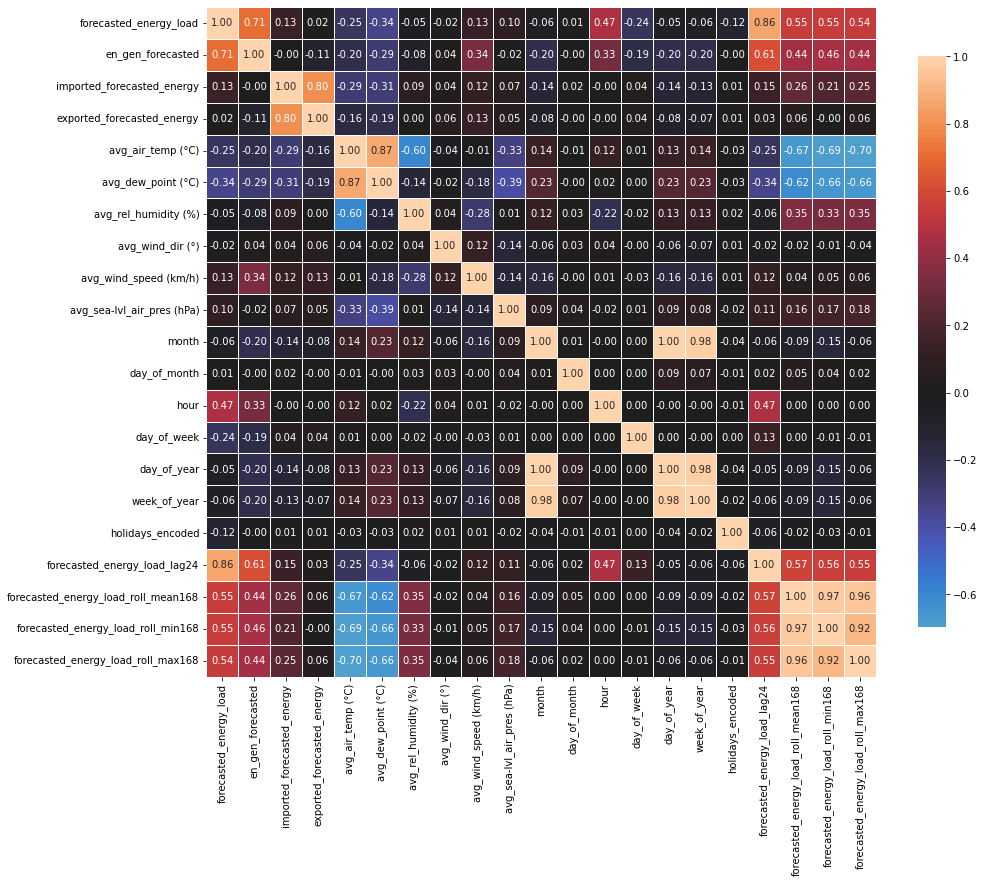

In [58]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(entsoe_meteostat_forecast_1)

### Trying to find the corelation between the features and our target ( forecasted_energy_load ) using the f_regression, mutual_info_regression models

C:\Users\Elena\miniconda3\envs\load_env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Elena\miniconda3\envs\load_env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


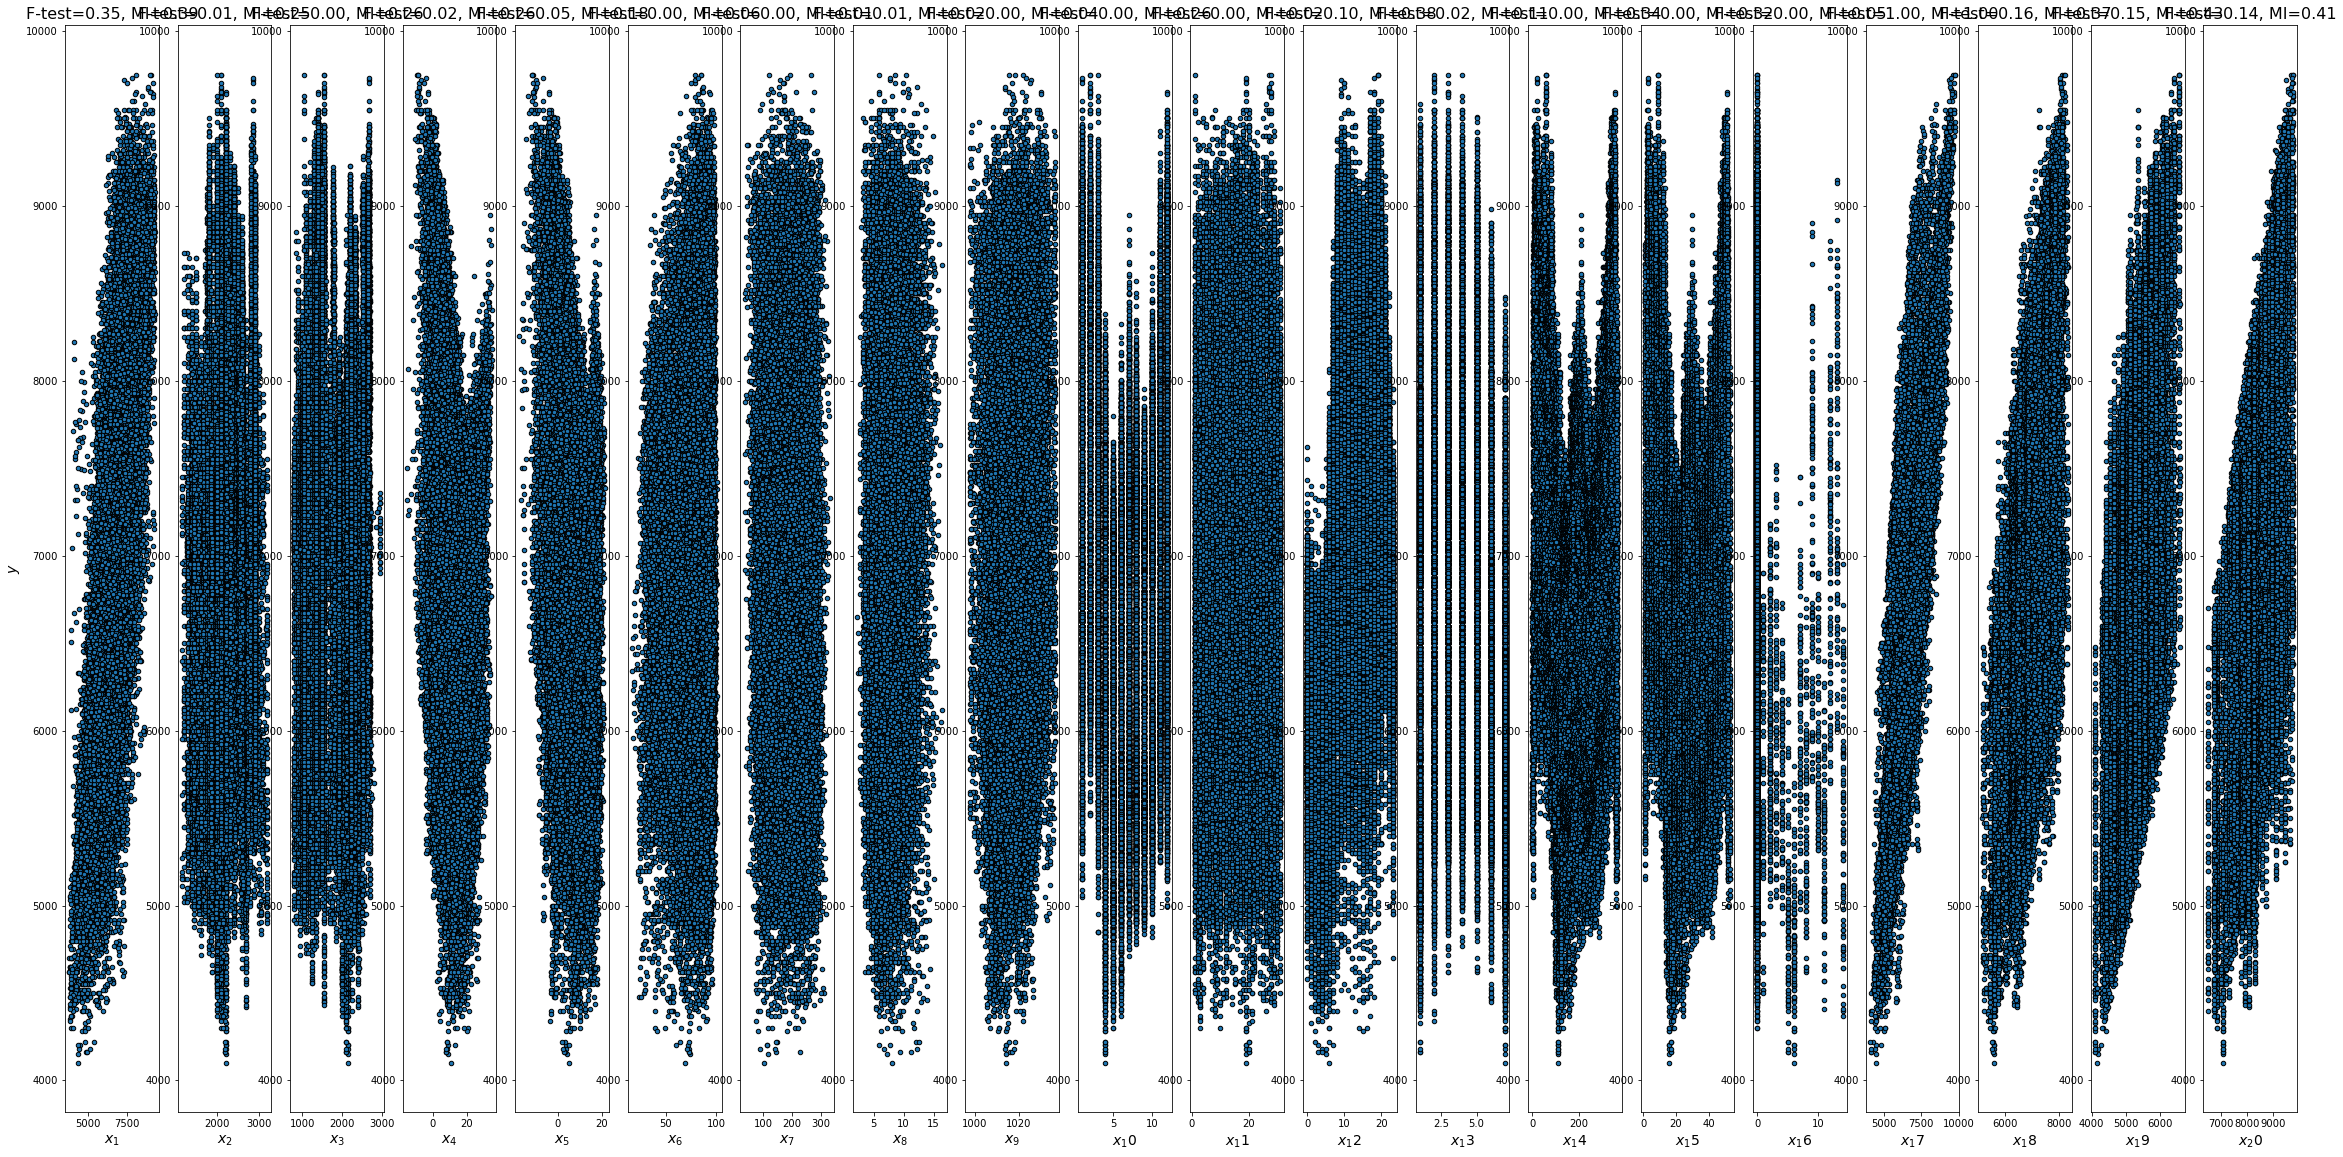

In [59]:
X = entsoe_meteostat_forecast_1.iloc[:, 1:].copy().values
y = pd.DataFrame(entsoe_meteostat_forecast_1.iloc[:,0]).copy().values

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

plt.figure(figsize=(40, 20))
for i in range(X.shape[1]):
    plt.subplot(1, X.shape[1], i + 1)
    plt.scatter(X[:, i], y, edgecolor="black", s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]), fontsize=16)
plt.show()

In [60]:
a = entsoe_meteostat_forecast_1.iloc[:, 1:]
for i in range(X.shape[1]):
    print(f"{a.columns[i]} : \n f_test = {f_test[i]}, mi = {mi[i]}")

en_gen_forecasted : 
 f_test = 0.3511070776043244, mi = 0.38611653290631415
imported_forecasted_energy : 
 f_test = 0.006251381594971353, mi = 0.24567124708525578
exported_forecasted_energy : 
 f_test = 9.75473769452681e-05, mi = 0.2632852556435678
avg_air_temp (°C) : 
 f_test = 0.02404018312816727, mi = 0.2585336351055643
avg_dew_point (°C) : 
 f_test = 0.046054776041548263, mi = 0.17824564731415254
avg_rel_humidity (%) : 
 f_test = 0.0007206985750516477, mi = 0.06267761761939371
avg_wind_dir (°) : 
 f_test = 0.00019627431119730943, mi = 0.010850088591433014
avg_wind_speed (km/h) : 
 f_test = 0.00596508435324379, mi = 0.016829567768580744
avg_sea-lvl_air_pres (hPa) : 
 f_test = 0.0038601004211585863, mi = 0.03602187372285635
month : 
 f_test = 0.0011361946992086995, mi = 0.2595022782759223
day_of_month : 
 f_test = 2.0228733651810337e-05, mi = 0.01994450516746561
hour : 
 f_test = 0.09948663001959339, mi = 0.3795571797566608
day_of_week : 
 f_test = 0.02178957732296826, mi = 0.1132054

### Eliminating the features with a low grade of correlation with the target

#### From all three corelation method we could see the following:
> The following features has a really low correlation with the target ( < 0,1)
>  * day_of_month
>  * avg_wind_dir

#### Because of their low grade of correlation they are irrelevant to the target so I will delete them.

> The following features had a high corelation between them ( > 0.8): 
> * avg_dew_point & avg_air_temp
> * day_of_year & month
> * week_of_year & month
> * day_of_year & week_of_year
> * forecasted_energy_load_roll_mean168  & forecasted_energy_load_roll_min168  
> * forecasted_energy_load_roll_mean168  & forecasted_energy_load_roll_max168  
> * forecasted_energy_load_roll_min168  & forecasted_energy_load_roll_max168 

#### To avoid Multicollinearity I will keep only one of the variable (the one who has the highest correlation with the target)

In [61]:
entsoe_meteostat_forecast_1.columns

Index(['forecasted_energy_load', 'en_gen_forecasted',
       'imported_forecasted_energy', 'exported_forecasted_energy',
       'avg_air_temp (°C)', 'avg_dew_point (°C)', 'avg_rel_humidity (%)',
       'avg_wind_dir (°)', 'avg_wind_speed (km/h)',
       'avg_sea-lvl_air_pres (hPa)', 'month', 'day_of_month', 'hour',
       'day_of_week', 'day_of_year', 'week_of_year', 'holidays_encoded',
       'forecasted_energy_load_lag24', 'forecasted_energy_load_roll_mean168',
       'forecasted_energy_load_roll_min168',
       'forecasted_energy_load_roll_max168'],
      dtype='object')

In [62]:
entsoe_meteostat_forecast_1 = entsoe_meteostat_forecast_1.drop(["day_of_month", "avg_wind_dir (°)", "avg_dew_point (°C)", "month", "week_of_year", "forecasted_energy_load_roll_mean168", "forecasted_energy_load_roll_max168"], axis =1)
entsoe_meteostat_forecast_1

forecasted_energy_load  en_gen_forecasted  \
timestamp                                                        
2017-10-03 01:00:00                  5800.0             5102.0   
2017-10-03 02:00:00                  5700.0             5074.0   
2017-10-03 03:00:00                  5670.0             5009.0   
2017-10-03 04:00:00                  5730.0             4999.0   
2017-10-03 05:00:00                  5900.0             5061.0   
...                                     ...                ...   
2021-12-31 19:00:00                  7802.5             6848.5   
2021-12-31 20:00:00                  7512.5             6657.0   
2021-12-31 21:00:00                  7180.0             6540.0   
2021-12-31 22:00:00                  6840.0             6425.0   
2021-12-31 23:00:00                  6480.0             6117.0   

                     imported_forecasted_energy  exported_forecasted_energy  \
timestamp                                                                     
2017-10-03 01:00:00                      1800.0                      1250.0   
2017-10-03 02:00:00                      1800.0                      1250.0   
2017-10-03 03:00:00                      1800.0                      1250.0   
2017-10-03 04:00:00                      1800.0                      1250.0   
2017-10-03 05:00:00                      1800.0                      1250.0   
...                                         ...                         ...   
2021-12-31 19:00:00                      2900.0                      2536.0   
2021-12-31 20:00:00                      2900.0                      2536.0   
2021-12-31 21:00:00                      2900.0                      2536.0   
2021-12-31 22:00:00                      2900.0                      2536.0   
2021-12-31 23:00:00                      2900.0                      2536.0   

                     avg_air_temp (°C)  avg_rel_humidity (%)  \
timestamp                                                      
2017-10-03 01:00:00             4.6125                91.250   
2017-10-03 02:00:00             4.2875                92.000   
2017-10-03 03:00:00             3.8625                93.625   
2017-10-03 04:00:00             3.6250                94.500   
2017-10-03 05:00:00             3.4500                93.625   
...                                ...                   ...   
2021-12-31 19:00:00             4.9625                93.000   
2021-12-31 20:00:00             4.6500                93.250   
2021-12-31 21:00:00             4.6750                93.500   
2021-12-31 22:00:00             4.7625                93.375   
2021-12-31 23:00:00             4.7750                92.500   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  hour  \
timestamp                                                                      
2017-10-03 01:00:00                 5.4000                   1025.8875   1.0   
2017-10-03 02:00:00                 5.4000                   1025.5000   2.0   
2017-10-03 03:00:00                 5.4000                   1025.4625   3.0   
2017-10-03 04:00:00                 5.4000                   1025.3375   4.0   
2017-10-03 05:00:00                 4.0500                   1025.2875   5.0   
...                                    ...                         ...   ...   
2021-12-31 19:00:00                10.4500                   1019.7875  19.0   
2021-12-31 20:00:00                10.7750                   1019.2250  20.0   
2021-12-31 21:00:00                10.9500                   1019.1000  21.0   
2021-12-31 22:00:00                10.2625                   1018.7500  22.0   
2021-12-31 23:00:00                10.1500                   1018.3375  23.0   

                     day_of_week  day_of_year  holidays_encoded  \
timestamp                                                         
2017-10-03 01:00:00          2.0        276.0               0.0   
2017-10-03 02:00:00          2.0        276.0              

# Introduce the new table in the database

In [63]:
entsoe_meteostat_forecast_1.to_sql("Feature_selected_forecasted_data", conn, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None, method=None)

C:\Users\Elena\miniconda3\envs\load_env\lib\site-packages\pandas\core\generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [64]:
entsoe = pd.read_sql("SELECT * FROM Feature_selected_forecasted_data;", conn)
entsoe

timestamp  forecasted_energy_load  en_gen_forecasted  \
0      2017-10-03 01:00:00                  5800.0             5102.0   
1      2017-10-03 02:00:00                  5700.0             5074.0   
2      2017-10-03 03:00:00                  5670.0             5009.0   
3      2017-10-03 04:00:00                  5730.0             4999.0   
4      2017-10-03 05:00:00                  5900.0             5061.0   
...                    ...                     ...                ...   
37214  2021-12-31 19:00:00                  7802.5             6848.5   
37215  2021-12-31 20:00:00                  7512.5             6657.0   
37216  2021-12-31 21:00:00                  7180.0             6540.0   
37217  2021-12-31 22:00:00                  6840.0             6425.0   
37218  2021-12-31 23:00:00                  6480.0             6117.0   

       imported_forecasted_energy  exported_forecasted_energy  \
0                          1800.0                      1250.0   
1                          1800.0                      1250.0   
2                          1800.0                      1250.0   
3                          1800.0                      1250.0   
4                          1800.0                      1250.0   
...                           ...                         ...   
37214                      2900.0                      2536.0   
37215                      2900.0                      2536.0   
37216                      2900.0                      2536.0   
37217                      2900.0                      2536.0   
37218                      2900.0                      2536.0   

       avg_air_temp (°C)  avg_rel_humidity (%)  avg_wind_speed (km/h)  \
0                 4.6125                91.250                 5.4000   
1                 4.2875                92.000                 5.4000   
2                 3.8625                93.625                 5.4000   
3                 3.6250                94.500                 5.4000   
4                 3.4500                93.625                 4.0500   
...                  ...                   ...                    ...   
37214             4.9625                93.000                10.4500   
37215             4.6500                93.250                10.7750   
37216             4.6750                93.500                10.9500   
37217             4.7625                93.375                10.2625   
37218             4.7750                92.500                10.1500   

       avg_sea-lvl_air_pres (hPa)  hour  day_of_week  day_of_year  \
0                       1025.8875   1.0          2.0        276.0   
1                       1025.5000   2.0          2.0        276.0   
2                       1025.4625   3.0          2.0        276.0   
3                       1025.3375   4.0          2.0        276.0   
4                       1025.2875   5.0          2.0        276.0   
...                           ...   ...          ...          ...   
37214                   1019.7875  19.0          5.0        365.0   
37215                   1019.2250  20.0          5.0        365.0   
37216                   1019.1000  21.0          5.0        365.0   
37217                   1018.7500  22.0          5.0        365.0   
37218                   1018.3375  23.0          5.0        365.0   

       holidays_encoded  forecasted_energy_load_lag24  \
0                   0.0                        5300.0   
1                   0.0                        5220.0   
2                   0.0                        5200.0   
3                   0.0                        5280.0   
4                   0.0                        5540.0   
...                 ...                           ...   
37214               0.0                        8135.0   
37215               0.0                        7917.5   
37216               0.0                        7525.0   
37217               0.0                        7020.0   
37218               0.0   

<AxesSubplot:xlabel='timestamp'>

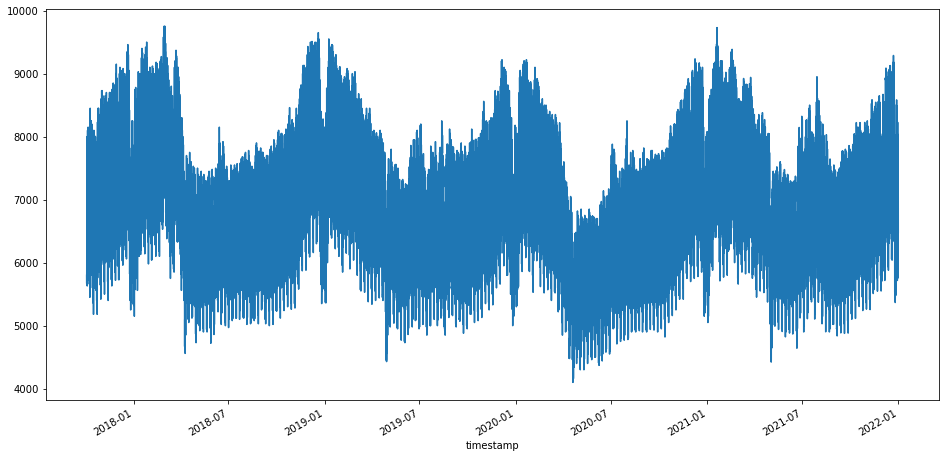

In [65]:
entsoe_meteostat_forecast_1["forecasted_energy_load"].plot(figsize = (16,8))